## <center>Анализ схем севооборота

Фермеры и агрохолдинги стремятся увеличивать доход, повышая урожайность и снижая издержки. Для этого применяется севооборот — поочерёдное выращивание различных культур: например, сначала сеют озимую рожь, на следующий год — картофель, потом — яровую пшеницу, а после неё — клевер. Это помогает бороться с сорняками и поддерживать плодородность почвы, обогащая её питательными веществами. Чередуя культуры определённом порядке, фермеры экономят на удобрениях и пестицидах.

Зная стратегии севооборота, которые применяют фермеры, можно предсказать, как будут изменяться характеристики почвы и урожайность. Это позволяет прогнозировать объём произведённых продуктов в масштабе регионов и государств, а также изменение цен на международном рынке сельхозпродукции.
    
Задачи проекта:  
* проанализировать набор данных,
* выявить последовательность смены посевных культур на заданных полях за десять лет,
* предсказать, какую культуру там сеяли в 2020 году.
 
Набор данных собран из открытой статистики о посевах во Франции за 2010–2019 год. Предсказание необходимо сделать для 100 полей в регионе Haute-de-France, а также в рандомизированной выборке из 100 000 полей для 2019 года (этой выборки не будет в представленном наборе данных).
Необходимо для каждой точки Point() вывести прогнозируемую культуру посева на указанный год в файле predict.csv.
    
### Оглавление:
[0. Установка параметров, импорт библиотек](#0.-Установка-параметров,-импорт-библиотек)

[1. Первичный анализ данных](#1.-Первичный-анализ-данных)

* [1.1. Словари](#1.1.-Словари)
* [1.2. Данные 2010-2014 гг.](#1.2.-Данные-2010-2014-гг.)
* [1.3. Данные train 2015-19 гг.](#1.3.-Данные-train-2015-19-гг.)
* [1.4. Данные test 2015-18 гг.](#1.4.-Данные-test-2015-18-гг.)
* [1.5. Данные test 2015-19 гг.](#1.5.-Данные-test-2015-19-гг.)

[2. Чистка данных и приведение форматов](#2.-Чистка-данных-и-приведение-форматов)
    
[3. Сборка баз для моделирования](#3.-Сборка-баз-для-моделирования)
* [3.1. Сборка базы для моделирования 2019 года](#3.1.-Сборка-базы-для-моделирования-2019-года)
* [3.2. Сборка базы для предсказания 2019 года](#3.2.-Сборка-базы-для-предсказания-2019-года)
* [3.3. Сборка базы для предсказания 2020 года](#3.3.-Сборка-базы-для-предсказания-2020-года)
* [3.4. Добавление департамента](#3.4.-Добавление-департамента)

[4. Моделирование](#4.-Моделирование)
* [4.1. Наивная модель](#4.1.-Наивная-модель)
* [4.2. Дерево решений](#4.2.-Дерево-решений)
* [4.3. Случайный лес](#4.3.-Случайный-лес)
* [4.4. Бустинг](#4.4.-Бустинг)

[5. Итоги](#5.-Итоги)

### 0. Установка параметров, импорт библиотек

In [1]:
#параметры
path_10_14 = './10-14' #папка с данными за 2010-2014 годы
path_train = './archive/train' #папка с данными по годам 2015-2019 для построения модели
path_test = './archive/test' #папка с данными по годам для тестирования модели
my_random = 42 #случайное число, если процедура позволяет или требует его задать

In [2]:
import numpy as np #массивы
import pandas as pd #работа с данными
import pickle #загрузка-выгрузка pickle-файлов

import matplotlib.pyplot as plt #графика
import seaborn as sns #графика
import os #работа с файловой системой

import category_encoders as ce #кодировка признаков

from sklearn import tree #дерево решений
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.model_selection import train_test_split #деление выборки на train/test
from sklearn.model_selection import StratifiedKFold #одинаковые результаты GridSearch при n_jobs > 1 
from sklearn.model_selection import GridSearchCV #подбор гиперпараметров
from sklearn import metrics #метрики

from catboost import CatBoostClassifier #бустинг

from IPython.display import display, HTML #параметры отображения

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 1000)

### 1. Первичный анализ данных

In [3]:
#папки для файлов по модели: pickle-файлы, итоговые базы
if not os.path.exists('./files'):
    os.makedirs('./files')

if not os.path.exists('./boosting'):
    os.makedirs('./boosting')

### 1.1. Словари

In [4]:
%%time

#словарь культур
df_dict = pd.read_csv('Codification_cultures_principales.csv')

#добавление столбца с числовым кодом растений - просто номер строки в словаре (с отсчетом от 1, а не от 0)
df_dict['код культуры'] = df_dict.index + 1

#перевод столбцов на русский язык. почему-то в словаре у столбца ' Code Groupe Culture' лишний пробел
column_dict = {
    'Code Culture': 'букв. код культуры',
    'Libellé Culture': 'культура',
    ' Code Groupe Culture': 'код группы культур',
    'Libellé Groupe Culture': 'группа культур'
}

df_dict = df_dict.rename(columns=column_dict)
display(df_dict.head(3))

#общие характеристики словаря
print(f"В словаре растений - {df_dict.shape[0]}, групп - {df_dict[['код группы культур']].nunique()[0] * 1}.")

,букв. код культуры,культура,код группы культур,группа культур,код культуры
0,BTH,Blé tendre dhiver,1,Blé tendre,1
1,BTP,Blé tendre de printemps,1,Blé tendre,2
2,MID,Maïs doux,2,Maïs grain et ensilage,3


В словаре растений - 310, групп - 24.
CPU times: total: 15.6 ms
Wall time: 28.3 ms


### 1.2. Данные 2010-2014 гг.  
Первичный анализ:

In [5]:
%%time

#загрузка файлов 2010-2014 годов
for year in range(2010, 2014 + 1):
    #выгрузка файла
    str_ = f"df_{year} = pd.read_csv('{path_10_14}/{year}.csv', low_memory=False)"
    exec(str_)

    #вывод года
    print(f"год = {year}:")

    #инфо о файле
    print('информация о файле:')
    str_ = f"df_{year}.info()"
    exec(str_)

    #вывод первых строк файла
    str_ = f"display(df_{year}.head(3))"
    exec(str_)

    #размер файла
    str_ = f"print('размер файла:', df_{year}.shape)"
    exec(str_)

    #количество полей
    str_ = f"print('количество полей:', df_{year}['centroid'].value_counts().shape[0])"
    exec(str_)

    #разница между кол-вом полей и кол-вом строк
    str_ = f"print('разница между кол-вом полей и строк:', df_{year}.shape[0] - df_{year}['centroid'].value_counts().shape[0])"
    exec(str_)

    #обрамление
    print('-----' * 10)

год = 2010:
информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6123259 entries, 0 to 6123258
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CULT_MAJ  int64 
 1   NUM_ILOT  object
 2   centroid  object
dtypes: int64(1), object(2)
memory usage: 140.2+ MB


,CULT_MAJ,NUM_ILOT,centroid
0,23,006-600,POINT (1036321.777965606 6313793.803955953)
1,23,006-601,POINT (1062367.545310645 6321180.197514395)
2,23,006-602,POINT (1062424.026822849 6321197.461531096)


размер файла: (6123259, 3)
количество полей: 6059673
разница между кол-вом полей и строк: 63586
--------------------------------------------------
год = 2011:
информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6033010 entries, 0 to 6033009
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CULT_MAJ  int64 
 1   NUM_ILOT  object
 2   centroid  object
dtypes: int64(1), object(2)
memory usage: 138.1+ MB


,CULT_MAJ,NUM_ILOT,centroid
0,23,006-638,POINT (1046728.207378248 6304020.605974536)
1,23,006-639,POINT (1046737.918209279 6303987.848531596)
2,23,006-640,POINT (1049257.306991662 6311438.956414687)


размер файла: (6033010, 3)
количество полей: 5973458
разница между кол-вом полей и строк: 59552
--------------------------------------------------
год = 2012:
информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6132686 entries, 0 to 6132685
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CULT_MAJ  int64 
 1   NUM_ILOT  object
 2   centroid  object
dtypes: int64(1), object(2)
memory usage: 140.4+ MB


,CULT_MAJ,NUM_ILOT,centroid
0,17,006-280520,POINT (1009188.658840747 6317747.347893714)
1,17,006-280521,POINT (1010437.822530566 6319065.034388192)
2,17,006-280522,POINT (1009540.728812411 6319282.28734187)


размер файла: (6132686, 3)
количество полей: 6073029
разница между кол-вом полей и строк: 59657
--------------------------------------------------
год = 2013:
информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6211872 entries, 0 to 6211871
Data columns (total 10 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CODE_CULTU  object
 1   COMMUNE     object
 2   DEP_RATTAC  object
 3   FORME_JURI  object
 4   NOM_CULTU   object
 5   NUM_ILOT    object
 6   SURF_CULTU  object
 7   SURF_DECLA  object
 8   SURF_GRAPH  object
 9   centroid    object
dtypes: object(10)
memory usage: 473.9+ MB


,CODE_CULTU,COMMUNE,DEP_RATTAC,FORME_JURI,NOM_CULTU,NUM_ILOT,SURF_CULTU,SURF_DECLA,SURF_GRAPH,centroid
0,28,2A189,02A,NR,DIVERS,02A-1955030,18.35,39.65,20.34,POINT (1193777.533092166 6084021.388247805)
1,18,2A189,02A,NR,PRAIRIES PERMANENTES,02A-1955031,13.49,39.65,16.68,POINT (1191353.759028711 6083937.263523669)
2,28,2A189,02A,NR,DIVERS,02A-1955032,2.11,39.65,2.63,POINT (1191004.412227421 6084026.964928603)


размер файла: (6211872, 10)
количество полей: 6084864
разница между кол-вом полей и строк: 127008
--------------------------------------------------
год = 2014:
информация о файле:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146401 entries, 0 to 6146400
Data columns (total 10 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CODE_CULTU  object
 1   COMMUNE     object
 2   DEP_RATTAC  object
 3   FORME_JURI  object
 4   NOM_CULTU   object
 5   NUM_ILOT    object
 6   SURF_CULTU  object
 7   SURF_DECLA  object
 8   SURF_GRAPH  object
 9   centroid    object
dtypes: object(10)
memory usage: 468.9+ MB


,CODE_CULTU,COMMUNE,DEP_RATTAC,FORME_JURI,NOM_CULTU,NUM_ILOT,SURF_CULTU,SURF_DECLA,SURF_GRAPH,centroid
0,17,2A118,02A,NR,ESTIVES LANDES,02A-1953831,1.96,135.06,3.13,POINT (1200094.702156055 6084023.249275596)
1,18,2A118,02A,NR,PRAIRIES PERMANENTES,02A-1953832,1.49,135.06,2.26,POINT (1200069.197270227 6084163.946189297)
2,17,2A310,02A,NR,ESTIVES LANDES,02A-1953833,18.29,135.06,25.83,POINT (1200398.534434257 6087386.679886134)


размер файла: (6146401, 10)
количество полей: 6095043
разница между кол-вом полей и строк: 51358
--------------------------------------------------
CPU times: total: 1min 38s
Wall time: 1min 38s


В данных 2010-12 годов всего 3 столбца - координаты центра участка, номер участка и группа культур, которая преобладала на участке.

В 2013-2014 годах данных больше. Есть текстовое описание группы культур, но уже с ходу не четко бьется с основным словарем: "ESTIVES LANDES" дается в словаре как "Estives et landes" - мелочь (et), но все же. Также и название меняется с CULT_MAJ на CODE_CULTU.

Более полезны данные о [департаменте](https://ru.wikipedia.org/wiki/Департаменты_Франции), [коммуне](https://ru.wikipedia.org/wiki/Коммуны_Франции), номере участка. Также есть сведения о площади (surf - surface), причем в 3 видах: засеянная, общая и еще какая-то. Вряд ли будет польза от площади, а вот от географии что-то может зависеть. Это и широтно-долготные показатели, и рельеф, и почвы, и климат (включая гидрологический режим) - беря департамент как переменную, считаем климатические показатели относительно однородными по всей его территории.

Еще есть поле FORME_JURI - что-то, связанное с организационно-правовой формой (ОПФ) владельца участка.
Основные группы:
* NR - похоже, что "не указано" (Non renseigné). Примем такой пропуск не заменить - и так самый частый  
* EARL - Сельскохозяйственное предприятие с ограниченной ответственностью (Exploitation agricole à responsabilité limitée)  
* GAEC - Объединенная фермерская группа (Groupement Agricole d'Exploitation en Commun)  
* SCEA - Гражданское общество сельскохозяйственной эксплуатации (Société civile d'exploitation agricole)  
* AFS - точное определение не нашел, но, видимо, есть Agricultural и France
* SARL - Общество с ограниченной ответственностью(Société à responsabilité limitée)

Остальных групп гораздо меньше - 0,4%. Раскладка по ОПФ:

In [6]:
%%time

#распределение по типам организаций-владельцев земли
percentage = (df_2014[['FORME_JURI']].value_counts(normalize=True).round(3) * 100).to_frame()
percentage = percentage.rename(columns={0: 'доля, %'})
percentage.index.names = ['форма']

print(percentage.iloc[0:6])
print('-----' * 5)
print(f"всего на первых 6 типов - {percentage.iloc[0:6].sum()[0]:.1f}%")

       доля, %
форма         
NR        46.6
EARL      27.0
GAEC      18.6
SCEA       6.0
AFS        0.8
SARL       0.6
-------------------------
всего на первых 6 типов - 99.6%
CPU times: total: 266 ms
Wall time: 272 ms


В данных 2013-2014 гг есть проблемы с числовыми полями - CODE_CULTU, а также поля о площади текстовые, хотя д.б. числовые. И конечно же находим там лишнее - 'NR', как и для организационно-правовых форм. Заодно убеждаемся, что code_cultu - это группа растений, а не конкретное растение, несмотря на название (в словаре кодов Code Culture - это именно трехбуквенное сокращение вида растений, а тут - группа).

In [7]:
%%time

print(df_2014['CODE_CULTU'].value_counts().sort_index())

01     824549
02     705679
03     306317
04     215959
05     202842
06     130070
07      17138
08      32401
09       7177
10      17498
13     208261
14        459
15       7469
16      29782
17     142423
18    1732966
19     895980
20      38770
21     374638
22      16296
23      14813
24      54090
25      72071
26          1
27       5006
28      93133
NR        613
Name: CODE_CULTU, dtype: int64
CPU times: total: 156 ms
Wall time: 161 ms


Замечаем также наличие кодов 10, 13, 26, а их нет в словаре. Надо проверять изменения словаря...

Также стоит отметить, что размеры таблиц за разные годы хоть и незначительно, но отличаются. Есть и дубли - поля с одинаковыми центрами, причем с 2010 по 2013 на первом месте - классический пропуск данных, выраженный словом "empty".
Примеры ниже:

In [8]:
%%time

for year in range(2010, 2014 + 1):
    #топ-10 полей с несколькими значениями
    print(f"топ-5 полей с несколькими значениями в {year} году:")
    str_ = f"print(df_{year}['centroid'].value_counts().to_frame(name='count')[0:5])"
    exec(str_)
    print('-----' * 10)

топ-5 полей с несколькими значениями в 2010 году:
                                             count
POINT EMPTY                                  11271
POINT (673764.3661274213 6414007.602436618)      7
POINT (704246.5553244811 6390450.108207119)      5
POINT (706027.9077705755 6995125.144923922)      4
POINT (816600.5195331434 6909247.598649477)      4
--------------------------------------------------
топ-5 полей с несколькими значениями в 2011 году:
                                             count
POINT EMPTY                                   9399
POINT (673764.3646639806 6414007.611131609)      6
POINT (701073.7879864465 7019255.504153179)      4
POINT (683388.0912123742 7001266.162855646)      4
POINT (535967.6767574587 6790090.173170066)      3
--------------------------------------------------
топ-5 полей с несколькими значениями в 2012 году:
                                             count
POINT EMPTY                                   7978
POINT (673764.3646639806 6414007.6

Примеры с дублями в разные годы ниже.  
Примеры 2010 года показывают, что есть поля с центром, которые, видимо, поделены на мелкие поля. Там культура может быть как одна, так и разные. Причем во втором примере разные первые числа (до дефиса) в поле NUM_ILOT.  
В примере 2014 года видно 2 пары идентичных (за исключением NUM_ILOT) пары строк. Тут тоже явная ошибка - т.к. DEP_RATTAC и первое число в NUM_ILOT должны бы совпадать, а тут не совпадают: 069 вместо 038.  
Похоже на то, что и во Франции проблемы с чистотой данных есть. 

In [9]:
%%time

print('поле 1 с дублями 2010 года:')
display(df_2010[df_2010['centroid'] == 'POINT (673764.3661274213 6414007.602436618)'])

print('поле 2 с дублями 2010 года:')
display(df_2010[df_2010['centroid'] == 'POINT (706027.9077705755 6995125.144923922)'])

print('поле с дублями 2014 года:')
display(df_2014[df_2014['centroid'] == 'POINT (867957.6751420358 6514636.34978814)'])

поле 1 с дублями 2010 года:


,CULT_MAJ,NUM_ILOT,centroid
3037528,18,012-34358,POINT (673764.3661274213 6414007.602436618)
3055457,18,012-52983,POINT (673764.3661274213 6414007.602436618)
3129618,18,012-126097,POINT (673764.3661274213 6414007.602436618)
3129925,18,012-127170,POINT (673764.3661274213 6414007.602436618)
3130420,18,012-126951,POINT (673764.3661274213 6414007.602436618)
3132054,18,012-129717,POINT (673764.3661274213 6414007.602436618)
3132241,18,012-129761,POINT (673764.3661274213 6414007.602436618)


поле 2 с дублями 2010 года:


,CULT_MAJ,NUM_ILOT,centroid
3799459,28,059-8500,POINT (706027.9077705755 6995125.144923922)
3810602,25,059-20468,POINT (706027.9077705755 6995125.144923922)
4898059,28,062-10358,POINT (706027.9077705755 6995125.144923922)
4957077,25,062-68740,POINT (706027.9077705755 6995125.144923922)


поле с дублями 2014 года:


,CODE_CULTU,COMMUNE,DEP_RATTAC,FORME_JURI,NOM_CULTU,NUM_ILOT,SURF_CULTU,SURF_DECLA,SURF_GRAPH,centroid
4541545,02,69299,038,EARL,MAIS GRAIN ET ENSILAGE,038-2592703,2.37,181.83,2.37,POINT (867957.6751420358 6514636.34978814)
4552722,07,69299,038,SCEA,AUTRES OLEAGINEUX,038-2602796,2.37,106.22,2.37,POINT (867957.6751420358 6514636.34978814)
4963766,02,69299,038,EARL,MAIS GRAIN ET ENSILAGE,069-4894866,2.37,181.83,2.37,POINT (867957.6751420358 6514636.34978814)
4970804,07,69299,038,SCEA,AUTRES OLEAGINEUX,069-4901574,2.37,106.22,2.37,POINT (867957.6751420358 6514636.34978814)


CPU times: total: 781 ms
Wall time: 793 ms


### 1.3. Данные train 2015-19 гг.

In [10]:
%%time

#загрузка файлов 2015-2019 годов
for year in range(2015, 2019 + 1):
    #выгрузка файла
    str_ = f"df_train_{year} = pd.read_csv('{path_train}/train_{year}.csv')"
    exec(str_)
    
    #вывод года
    print(f"year = {year}:")
    
    #вывод первых строк файла
    str_ = f"display(df_train_{year}.head(3))"
    exec(str_)
    
    #размер файла
    str_ = f"print('размер файла:', df_train_{year}.shape)"
    exec(str_)
    
    #количество полей
    str_ = f"print('количество полей:', df_train_{year}['centroid'].value_counts().shape[0])"
    exec(str_)
    
    #разница между кол-вом полей и кол-вом строк
    str_ = f"print('разница полей и строк:', df_train_{year}.shape[0] - df_train_{year}['centroid'].value_counts().shape[0])"
    exec(str_)
    
    #обрамление
    print('-----' * 10)

year = 2015:


,CODE_CULTU,CODE_GROUP,centroid
0,PPH,18,Point (907753.82834152 6554634.46488151)
1,PPH,18,Point (906932.34642625 6550537.14396784)
2,PPH,18,Point (906441.41841629 6551578.77930484)


размер файла: (3614804, 3)
количество полей: 3614804
разница полей и строк: 0
--------------------------------------------------
year = 2016:


,CODE_CULTU,CODE_GROUP,centroid
0,PPH,18,Point (840152.19502497 6541032.5295243)
1,PPH,18,Point (840235.9988251 6543961.07028867)
2,PPH,18,Point (840068.73460091 6540756.38446209)


размер файла: (3614804, 3)
количество полей: 3614804
разница полей и строк: 0
--------------------------------------------------
year = 2017:


,CODE_CULTU,CODE_GROUP,centroid
0,BTH,1,Point (851508.08037444 6581751.02886827)
1,PPH,18,Point (851469.15696846 6581643.76656947)
2,PPH,18,Point (851441.70952241 6581764.92460618)


размер файла: (3614804, 3)
количество полей: 3614804
разница полей и строк: 0
--------------------------------------------------
year = 2018:


,CODE_CULTU,CODE_GROUP,centroid
0,ORH,3,Point (849615.53291187 6550820.88855134)
1,ORH,3,Point (836311.90625009 6541329.39812208)
2,SOG,4,Point (836631.56083677 6542129.13323298)


размер файла: (3614804, 3)
количество полей: 3614804
разница полей и строк: 0
--------------------------------------------------
year = 2019:


,CODE_CULTU,CODE_GROUP,centroid
0,BTH,1,Point (700875.35400312 6883182.5138489)
1,MIS,2,Point (694778.65720113 6859704.83777004)
2,J6S,11,Point (694296.76067938 6859456.47459497)


размер файла: (3614804, 3)
количество полей: 3614804
разница полей и строк: 0
--------------------------------------------------
CPU times: total: 42.5 s
Wall time: 42.5 s


Данные более однотипные - 3 столбца: культура, группа культуры (в кодах) и центр участка. Центр участка является единым сквозным полем для соединения таблиц. Количество строк одинаковое, что вполне разумно и логично.

Поля (их центры) тоже уникальные. Но при добавлении информации о полях необходимо проверять количество строк в итоговой таблице.

### 1.4. Данные test 2015-18 гг.

In [11]:
%%time

#загрузка файлов 2015-2018 годов
for year in range(2015, 2018 + 1):
    #выгрузка файла
    str_ = f"df_test_{year} = pd.read_csv('{path_test}/test 2019/test_{year}.csv')"
    exec(str_)
    
    #вывод года
    print(f"year = {year}:")
    
    #вывод первых строк файла
    str_ = f"display(df_test_{year}.head(3))"
    exec(str_)
    
    #размер файла
    str_ = f"print('размер файла:', df_test_{year}.shape)"
    exec(str_)
    
    #разница между кол-вом полей и кол-вом строк
    str_ = f"print('разница полей и строк:', df_test_{year}.shape[0] - df_test_{year}['centroid'].value_counts().shape[0])"
    exec(str_)
    
    #обрамление
    print('-----' * 10)

year = 2015:


,CODE_CULTU,CODE_GROUP,centroid
0,PPH,18,Point (882657.94895066 6569342.10998129)
1,PPH,18,Point (882115.97784605 6572755.67171272)
2,TTH,4,Point (881577.18757373 6569639.00274748)


размер файла: (401645, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2016:


,CODE_CULTU,CODE_GROUP,centroid
0,MIS,2,Point (841083.89262071 6543276.8152431)
1,PPH,18,Point (840418.47029444 6542931.38149701)
2,PPH,18,Point (846720.04234456 6536460.19344079)


размер файла: (401645, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2017:


,CODE_CULTU,CODE_GROUP,centroid
0,PPH,18,Point (851684.78236408 6581318.76964295)
1,PPR,8,Point (878976.98019442 6548678.32810887)
2,SGH,4,Point (849537.96583142 6589422.14882691)


размер файла: (401645, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2018:


,CODE_CULTU,CODE_GROUP,centroid
0,J6S,11,Point (837113.21815327 6542642.03294466)
1,PTR,19,Point (859951.6897682 6548701.23025595)
2,BTH,1,Point (869152.69888415 6554341.41204209)


размер файла: (401645, 3)
разница полей и строк: 0
--------------------------------------------------
CPU times: total: 2.3 s
Wall time: 2.31 s


Тоже по 3 поля, как и в данных 2015-19 гг для train, надо предсказать 2019 год. Количество строк тоже одинаковое, как и на train. Всего train + test = 3 614 804 + 401 645 = 4 016 449. test равен 10% от этого числа. Странно что одного поля до 4 016 450 не хватает.

### 1.5. Данные test 2015-19 гг.

In [12]:
%%time

#загрузка файлов 2015-2019 годов
for year in range(2015, 2019 + 1):
    #выгрузка файла
    str_ = f"df_test2_{year} = pd.read_csv('{path_test}/test 2020/test_{year}.csv')"
    exec(str_)
    
    #вывод года
    print(f"year = {year}:")
    
    #вывод первых строк файла
    str_ = f"display(df_test2_{year}.head(3))"
    exec(str_)
    
    #размер файла
    str_ = f"print('размер файла:', df_test2_{year}.shape)"
    exec(str_)
    
    #разница между кол-вом полей и кол-вом строк
    str_ = f"print('разница полей и строк:', df_test2_{year}.shape[0] - df_test2_{year}['centroid'].value_counts().shape[0])"
    exec(str_)
    #обрамление
    print('-----' * 10)

year = 2015:


,CODE_CULTU,CODE_GROUP,centroid
0,FAG,16,Point (645709.52436221 7099158.66801243)
1,PRL,18,Point (632520.96052772 7100339.0240513)
2,PTC,25,Point (631011.98206993 7099882.1045089)


размер файла: (27, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2016:


,CODE_CULTU,CODE_GROUP,centroid
0,PTC,25,Point (627605.22448927 7090230.8672196)
1,J6S,11,Point (660112.10267566 7103917.32070282)
2,BTH,1,Point (639989.14607017 7094028.20936)


размер файла: (27, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2017:


,CODE_CULTU,CODE_GROUP,centroid
0,BTH,1,Point (627605.22448927 7090230.8672196)
1,LIF,9,Point (627135.06775911 7089790.96960391)
2,BTA,28,Point (626971.98061619 7089562.84166516)


размер файла: (27, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2018:


,CODE_CULTU,CODE_GROUP,centroid
0,BTN,24,Point (627605.22448927 7090230.8672196)
1,BTN,24,Point (627421.63137083 7089348.4473994)
2,BTH,1,Point (628059.94205405 7090942.4387415)


размер файла: (27, 3)
разница полей и строк: 0
--------------------------------------------------
year = 2019:


,CODE_CULTU,CODE_GROUP,centroid
0,BTH,1,Point (625771.91344838 7090455.27713006)
1,ORP,3,Point (628059.94205405 7090942.4387415)
2,BTH,1,Point (623112.8850607 7091321.76633075)


размер файла: (27, 3)
разница полей и строк: 0
--------------------------------------------------
CPU times: total: 62.5 ms
Wall time: 44 ms


Дано 27 участков, на которых надо предсказать культуру 2020 года. Дублей нет.

### 2. Чистка данных и приведение форматов
Так как в данных 2010-2012 гг. нельзя определить, какая из записей неверная при одном и том же поле, вычистить не получится.  
Для данных 2013-2014 гг можно выполнить удаление строк с текстовыми значениями, которые по смыслу являются числовыми, и изменить формат на числовой.

In [13]:
%%time

def data_clean(data):
    '''
    Функция очистки данных от текста NR в поле CODE_CULTU.
    Также преобразует поле CODE_CULTU в целочисленное поле CULT_MAJ (соответствуя названиям 2010-2013 гг),
    а поля 'SURF_CULTU', 'SURF_DECLA', 'SURF_GRAPH' преобразует в float64
    
    Args:
        data - исходная база
        
    Returns:
        data_mod - итоговая база
    '''

    #копия базы
    data_mod = data.copy()
    
    #очистка от NR
    data_mod = data_mod[data['CODE_CULTU'] != 'NR']

    #новое поле с нужным именем
    data_mod['CULT_MAJ'] = data_mod['CODE_CULTU'].astype('int64')
    
    #преобразование типов
    data_mod[['SURF_CULTU', 'SURF_DECLA', 'SURF_GRAPH']] = data_mod[[
        'SURF_CULTU', 'SURF_DECLA', 'SURF_GRAPH'
    ]].astype('float64')

    print(data_mod.info())

    return data_mod
    
df_2013 = data_clean(data=df_2013)
df_2014 = data_clean(data=df_2014)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6210878 entries, 0 to 6211871
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   CODE_CULTU  object 
 1   COMMUNE     object 
 2   DEP_RATTAC  object 
 3   FORME_JURI  object 
 4   NOM_CULTU   object 
 5   NUM_ILOT    object 
 6   SURF_CULTU  float64
 7   SURF_DECLA  float64
 8   SURF_GRAPH  float64
 9   centroid    object 
 10  CULT_MAJ    int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 568.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6145788 entries, 0 to 6146400
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   CODE_CULTU  object 
 1   COMMUNE     object 
 2   DEP_RATTAC  object 
 3   FORME_JURI  object 
 4   NOM_CULTU   object 
 5   NUM_ILOT    object 
 6   SURF_CULTU  float64
 7   SURF_DECLA  float64
 8   SURF_GRAPH  float64
 9   centroid    object 
 10  CULT_MAJ    int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 5

### 3. Сборка баз для моделирования  
Так как надо моделировать 2019 и 2020 год, то создание баз для моделирования и предсказания приобретает свои тонкости.

Для 2019 года мы можем использовать массив данных за 2010-2018 годы, причем для 2010-14 есть только группа культур, а для 2015 по 2018 - конкретная культура. Т.е. для года t (= 2019) в годы \[t-1, t-4\] есть конкретная культура, а в годы \[t-5, t-9\] - группа культур.  
Такую же структуру нужно получить и для моделирования 2020 года: 2016-2019 - конкретная культура, 2011-2015 - группа культур.

По идее административно-территориальное деление Франции не менялось, так что принадлежность участка департаменту можно считать постоянной. А вот сам участок мог поменять хозяина, либо же сам хозяин - сменить ОПФ. Поэтому если и брать эту переменную, то только в виде "ОПФ владельца участка за 6 лет то года моделирования" - 2013 год для прогноза на 2019 и 2014 год - для 2020.

#### 3.1. Сборка базы для моделирования 2019 года

In [14]:
%%time

#функция выделения координат из столбца centroid
def coords(centroid):
    '''
    функция выделения координат из столбца centroid
    
    Args:
        centroid - поле вида "Point (700875.35400312 6883182.5138489)" с координатами
    
    Returns:
        x - долгота по Lambert-93
        y - широта по Lambert-93
    
    '''

    #удаление скобок
    coords = centroid[centroid.find('(') + 1:centroid.find(')')]

    #широта - до пробела
    x = float(coords[:coords.find(' ')])

    #долгота - после пробела
    y = float(coords[coords.find(' ') + 1:])

    return x, y

#функция добавления культуры и группы культур из базы n лет назад - для баз с культурой и группой культур
def add_plant(data_base, data_add, n):
    '''
    Функция добавления культуры и группы культур из базы n лет назад
    
    Args:
        data_base - исходная база
        data_add - добавляемая база
        n - число лет назад от предсказываемого / моделируемого года
    
    Returns:
        data_out - база с добавлеными полями
    '''

    data_out = data_base.merge(
        data_add[['centroid', 'CODE_CULTU', 'CODE_GROUP']].rename(
        columns={'CODE_CULTU': 'cult t-' + str(n), 'CODE_GROUP': 'gr t-' + str(n)}
        ),
        on='centroid',
        how='left'
    )
    
    return data_out

#функция добавления группы культур из базы n лет назад - для баз с группой
def add_group(data_base, data_add, n):
    '''
    Функция добавления культуры и группы культур из базы n лет назад
    
    Args:
        data_base - исходная база
        data_add - добавляемая база
        n - число лет назад от предсказываемого / моделируемого года
    
    Returns:
        data_out - база с добавлеными полями
    '''
    
    temp_table = data_add.copy()
    temp_table['centroid'] = temp_table['centroid'].str.title()

    #слияние баз
    data_out = data_base.merge(
        temp_table[['centroid', 'CULT_MAJ']].rename(columns={'CULT_MAJ': 'gr t-' + str(n)}),
        on='centroid',
        how='left'
    )
    
    return data_out

#инициализация базы
df_tr_2019 = df_train_2019.copy()

#добавочные инрформационные поля
#год анализа
df_tr_2019['year_modelling'] = 2019
#тип базы
df_tr_2019['type'] = 'modelling'

#выделение координат
df_tr_2019[['x', 'y']] = df_tr_2019['centroid'].apply(coords).to_list()

#добавление данных 2015-2018 гг
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2018, n=1)
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2017, n=2)
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2016, n=3)
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2015, n=4)

#добавление данных 2010-2014 гг
df_tr_2019 = add_group(data_base=df_tr_2019, data_add=df_2014, n=5)
df_tr_2019 = add_group(data_base=df_tr_2019, data_add=df_2013, n=6)
df_tr_2019 = add_group(data_base=df_tr_2019, data_add=df_2012, n=7)
df_tr_2019 = add_group(data_base=df_tr_2019, data_add=df_2011, n=8)
df_tr_2019 = add_group(data_base=df_tr_2019, data_add=df_2010, n=9)

CPU times: total: 1min 21s
Wall time: 1min 23s


Но почему-то данные до 2015 года не присоединяются:

In [15]:
%%time

#вывод первых записей таблицы
display(df_tr_2019.head(5))

#сколько полей не присоединилось за годы 2010-2014
for i in range(5, 9 + 1):
    print(f"за {2019 - i} год не присоединилось {df_tr_2019[f'gr t-{i}'].isna().sum()} полей")

,CODE_CULTU,CODE_GROUP,centroid,year_modelling,type,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4,gr t-5,gr t-6,gr t-7,gr t-8,gr t-9
0,BTH,1,Point (700875.35400312 6883182.5138489),2019,modelling,700875.354003,6.883183e+06,BTN,24,BTH,1,BTH,1,BTN,24,NaN,NaN,NaN,NaN,NaN
1,MIS,2,Point (694778.65720113 6859704.83777004),2019,modelling,694778.657201,6.859705e+06,BTH,1,BTP,1,BTH,1,BTH,1,NaN,NaN,NaN,NaN,NaN
2,J6S,11,Point (694296.76067938 6859456.47459497),2019,modelling,694296.760679,6.859456e+06,J6S,11,J6S,11,J6S,11,J6S,11,NaN,NaN,NaN,NaN,NaN
3,BTH,1,Point (691746.7164862 6849822.75912715),2019,modelling,691746.716486,6.849823e+06,MIS,2,BTH,1,BTH,1,BTH,1,NaN,NaN,NaN,NaN,NaN
4,BTH,1,Point (691729.79132129 6849590.80278803),2019,modelling,691729.791321,6.849591e+06,MIS,2,BTH,1,MIS,2,BTH,1,NaN,NaN,NaN,NaN,NaN


за 2014 год не присоединилось 3614503 полей
за 2013 год не присоединилось 3614580 полей
за 2012 год не присоединилось 3614807 полей
за 2011 год не присоединилось 3614807 полей
за 2010 год не присоединилось 3614807 полей
CPU times: total: 62.5 ms
Wall time: 52 ms


In [16]:
%%time

display(HTML("<style>div.output_scroll {height: 30em;}</style>"))

#поиск совпадений координат точки Point (700875.35400312 6883182.5138489) - первая в dataframe выше - в 2010-2014 гг
for year in range(2010, 2014 + 1):
    print(f"{year} год:")
    #извлечение полей с одинаковой целой частью второй координаты
    str_ = f"display(df_{year}[df_{year}['centroid'].str.contains(' 6883182')].sort_values('centroid'))"
    exec(str_)

2010 год:


,CULT_MAJ,NUM_ILOT,centroid
5017467,2,067-15351,POINT (1046082.143600274 6883182.353904927)
5047178,2,067-45146,POINT (1048357.147145936 6883182.410990763)
5111252,3,067-112144,POINT (1050484.447941397 6883182.6259691)
5117286,18,067-115651,POINT (1056417.846912952 6883182.025309109)
769541,18,014-17098,POINT (415761.3009081839 6883182.043927396)
3442351,1,078-904,POINT (592029.6099015807 6883182.764500922)
4343583,1,095-6009,POINT (666744.5469098976 6883182.975844629)
742992,1,002-51525,POINT (714227.2762819002 6883182.550967762)
3467306,18,057-8684,POINT (968577.4296355509 6883182.86115436)
3480450,18,057-21942,POINT (991757.9749482663 6883182.148119025)


2011 год:


,CULT_MAJ,NUM_ILOT,centroid
5006104,1,067-92309,POINT (1046082.125206494 6883182.381629401)
4963135,2,067-48807,POINT (1048357.159795701 6883182.477214704)
4957607,2,067-42517,POINT (1050484.397279761 6883182.570217496)
5043480,18,067-129899,POINT (1056417.842565141 6883182.024426827)
3198327,5,078-6241,POINT (592029.5806438077 6883182.7614511)
3581112,18,057-58962,POINT (968577.442747728 6883182.854416864)
3583090,18,057-61861,POINT (991758.0091376684 6883182.222530235)


2012 год:


,CULT_MAJ,NUM_ILOT,centroid
5802880,2,067-4748128,POINT (1046082.125206494 6883182.381629401)
5847068,2,067-4793141,POINT (1048357.159795701 6883182.477214704)
5775163,2,067-4720615,POINT (1050484.397279761 6883182.570217496)
5850128,18,067-4794368,POINT (1056417.842565141 6883182.024426827)
3515317,1,078-5349913,POINT (592029.5806438077 6883182.7614511)
4232406,25,095-6125795,POINT (666744.5626539469 6883182.968359023)
3489599,18,057-3938458,POINT (968577.442747728 6883182.854416864)


2013 год:


,CODE_CULTU,COMMUNE,DEP_RATTAC,FORME_JURI,NOM_CULTU,NUM_ILOT,SURF_CULTU,SURF_DECLA,SURF_GRAPH,centroid,CULT_MAJ
3156611,01,67259,067,NR,BLE TENDRE,067-4806439,1.47,39.59,1.47,POINT (1046082.141057237 6883182.363815233),1
3095390,02,67160,067,NR,MAIS GRAIN ET ENSILAGE,067-4746009,0.38,101.31,0.38,POINT (1048357.148568064 6883182.433166672),2
3037313,03,67160,067,NR,ORGE,067-4686843,0.53,12.93,0.53,POINT (1050484.425304421 6883182.58896295),3
3152683,18,67474,067,NR,PRAIRIES PERMANENTES,067-4802205,0.21,75.49,0.21,POINT (1056417.857255186 6883182.031249329),18
60263,01,78320,078,EARL,BLE TENDRE,078-5357794,2.87,151.91,2.87,POINT (592029.6093779507 6883182.770568724),1
95160,01,95154,095,SCEA,BLE TENDRE,095-6139101,3.88,493.56,3.88,POINT (666744.5494483477 6883182.96799484),1
2984294,18,57088,057,NR,PRAIRIES PERMANENTES,057-3928835,0.63,52.07,0.63,POINT (968577.4235465036 6883182.869767979),18


2014 год:


,CODE_CULTU,COMMUNE,DEP_RATTAC,FORME_JURI,NOM_CULTU,NUM_ILOT,SURF_CULTU,SURF_DECLA,SURF_GRAPH,centroid,CULT_MAJ
3159249,02,67259,067,NR,MAIS GRAIN ET ENSILAGE,067-4806543,1.47,39.59,1.47,POINT (1046082.141057237 6883182.363815233),2
3126909,02,67160,067,NR,MAIS GRAIN ET ENSILAGE,067-4774283,0.38,101.31,0.38,POINT (1048357.148568064 6883182.433166672),2
3147189,18,67474,067,NR,PRAIRIES PERMANENTES,067-4793823,0.21,75.49,0.21,POINT (1056417.857255186 6883182.031249329),18
73788,03,78320,078,EARL,ORGE,078-5372846,2.87,153.18,2.87,POINT (592029.6093779507 6883182.770568724),3
93854,02,95154,095,SCEA,MAIS GRAIN ET ENSILAGE,095-6139175,3.88,498.68,3.88,POINT (666744.5494483477 6883182.96799484),2
2926591,18,55462,055,AOP,PRAIRIES PERMANENTES,055-3786588,3.85,102.54,3.85,POINT (897384.4900627242 6883182.120108765),18
3010878,18,57088,057,NR,PRAIRIES PERMANENTES,057-3956360,0.63,52.07,0.63,POINT (968577.4235465036 6883182.869767979),18


CPU times: total: 10.9 s
Wall time: 10.9 s


Как видно по одному этому примеру, координаты почему-то раньше были другие. Так, ни у одного участка нет первой координаты 700875. Количество участков само по себе скачет. И даже хотя в 2013 и 2014 годах по 7 участков с одинаковой целой частью второй координаты, причем пары координат в основном совпадают, то все равно есть разница: в 2013 году был участок "POINT (1050484.425304421 6883182.58896295)", а в 2014 появился "POINT (897384.4900627242 6883182.120108765)". Таким образом, предысторию в части типа культуры точно на конкретном участке за эти годы нам получить не удастся. Попробуем тогда хотя бы получить номер департамента. А пока создадим базы для теста за 2019 и 2020 год.

И заново соберем базу (при соединении с данными 2010-2014 гг хоть и ничего почти не присоединилось, но из того, что присоединилось, появились дубли).

In [17]:
%%time

diff = df_tr_2019.shape[0] - df_train_2019.shape[0]
print(f"разница в кол-ве записей до и после обогащения 2010-2014 гг: {diff}.")

разница в кол-ве записей до и после обогащения 2010-2014 гг: 3.
CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
%%time

#пересборка - перезапуск уже запускавшегося для сборки базы кода, но без присоединения 2010-2014
#инициализация базы
df_tr_2019 = df_train_2019.copy()

#добавочные инрформационные поля
#год анализа
df_tr_2019['year_modelling'] = 2019
#тип базы
df_tr_2019['type'] = 'modelling'

#выделение координат
df_tr_2019[['x', 'y']] = df_tr_2019['centroid'].apply(coords).to_list()

#добавление данных 2015-2018 гг
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2018, n=1)
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2017, n=2)
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2016, n=3)
df_tr_2019 = add_plant(data_base=df_tr_2019, data_add=df_train_2015, n=4)

display(df_tr_2019.head(3))

,CODE_CULTU,CODE_GROUP,centroid,year_modelling,type,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4
0,BTH,1,Point (700875.35400312 6883182.5138489),2019,modelling,700875.354003,6.883183e+06,BTN,24,BTH,1,BTH,1,BTN,24
1,MIS,2,Point (694778.65720113 6859704.83777004),2019,modelling,694778.657201,6.859705e+06,BTH,1,BTP,1,BTH,1,BTH,1
2,J6S,11,Point (694296.76067938 6859456.47459497),2019,modelling,694296.760679,6.859456e+06,J6S,11,J6S,11,J6S,11,J6S,11


CPU times: total: 27.1 s
Wall time: 27.1 s


#### 3.2. Сборка базы для предсказания 2019 года

In [19]:
%%time

#инициализация базы
df_pred_2019 = df_test_2018.copy()

#сброс значений - мы их предсказываем
df_pred_2019['CODE_CULTU'] = '-1'
df_pred_2019['CODE_GROUP'] = '-1'

#добавочные информационные поля 
#год анализа
df_pred_2019['year_modelling'] = 2019
#тип базы
df_pred_2019['type'] = 'predict2019'

#выделение координат
df_pred_2019[['x', 'y']] = df_pred_2019['centroid'].apply(coords).to_list()

#добавление данных 2015-2018 гг
df_pred_2019 = add_plant(data_base=df_pred_2019, data_add=df_test_2018, n=1)
df_pred_2019 = add_plant(data_base=df_pred_2019, data_add=df_test_2017, n=2)
df_pred_2019 = add_plant(data_base=df_pred_2019, data_add=df_test_2016, n=3)
df_pred_2019 = add_plant(data_base=df_pred_2019, data_add=df_test_2015, n=4)

display(df_pred_2019.head(3))

,CODE_CULTU,CODE_GROUP,centroid,year_modelling,type,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4
0,-1,-1,Point (837113.21815327 6542642.03294466),2019,predict2019,837113.218153,6.542642e+06,J6S,11,J6S,11,J6S,11,J6S,11
1,-1,-1,Point (859951.6897682 6548701.23025595),2019,predict2019,859951.689768,6.548701e+06,PTR,19,PTR,19,PTR,19,BTH,1
2,-1,-1,Point (869152.69888415 6554341.41204209),2019,predict2019,869152.698884,6.554341e+06,BTH,1,MIS,2,MIS,2,BTH,1


CPU times: total: 2.27 s
Wall time: 2.26 s


#### 3.3. Сборка базы для предсказания 2020 года

In [20]:
%%time

#инициализация базы
df_pred_2020 = df_test2_2019.copy()

#сброс значений - мы их предсказываем
df_pred_2020['CODE_CULTU'] = '-1'
df_pred_2020['CODE_GROUP'] = '-1'

#добавочные информационные поля 
#год анализа
df_pred_2020['year_modelling'] = 2020
#тип базы
df_pred_2020['type'] = 'predict2020'

#выделение координат
df_pred_2020[['x', 'y']] = df_pred_2020['centroid'].apply(coords).to_list()

#добавление данных 2016-2019 гг
df_pred_2020 = add_plant(data_base=df_pred_2020, data_add=df_test2_2019, n=1)
df_pred_2020 = add_plant(data_base=df_pred_2020, data_add=df_test2_2018, n=2)
df_pred_2020 = add_plant(data_base=df_pred_2020, data_add=df_test2_2017, n=3)
df_pred_2020 = add_plant(data_base=df_pred_2020, data_add=df_test2_2016, n=4)

display(df_pred_2020.head(3))

,CODE_CULTU,CODE_GROUP,centroid,year_modelling,type,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4
0,-1,-1,Point (625771.91344838 7090455.27713006),2020,predict2020,625771.913448,7.090455e+06,BTH,1,PTC,25,BTH,1,BTN,24
1,-1,-1,Point (628059.94205405 7090942.4387415),2020,predict2020,628059.942054,7.090942e+06,ORP,3,BTH,1,CZH,5,BTH,1
2,-1,-1,Point (623112.8850607 7091321.76633075),2020,predict2020,623112.885061,7.091322e+06,BTH,1,LIF,9,BTH,1,PTC,25


CPU times: total: 15.6 ms
Wall time: 19 ms


#### 3.4. Добавление департамента

In [21]:
%%time

#соединение баз в одну
df_all =  pd.concat([df_tr_2019, df_pred_2019, df_pred_2020], axis=0)

#подсчет кол-ва значений по типам выборок
df_all['type'].value_counts(dropna=False)

CPU times: total: 203 ms
Wall time: 201 ms


modelling      3614804
predict2019     401645
predict2020         27
Name: type, dtype: int64

In [22]:
%%time

#создание базы для моделирования департаметов
df_2014_dep = df_2014[['COMMUNE', 'DEP_RATTAC', 'centroid']].copy()

#выделение координат
df_2014_dep[['x', 'y']] = df_2014_dep['centroid'].apply(coords).to_list()
display(df_2014_dep.head(3))

,COMMUNE,DEP_RATTAC,centroid,x,y
0,2A118,02A,POINT (1200094.702156055 6084023.249275596),1.200095e+06,6.084023e+06
1,2A118,02A,POINT (1200069.197270227 6084163.946189297),1.200069e+06,6.084164e+06
2,2A310,02A,POINT (1200398.534434257 6087386.679886134),1.200399e+06,6.087387e+06


CPU times: total: 12 s
Wall time: 12 s


In [23]:
%%time

#выгрузка баз в pickle-файлы для разметки на департаменты
with open('./files/df_all.pkl', 'wb') as output:
    pickle.dump(df_all, output)

with open('./files/df_2014_dep.pkl', 'wb') as output:
    pickle.dump(df_2014_dep, output)

CPU times: total: 4.67 s
Wall time: 4.8 s


Для разметки полей по департаментам был проведен анализ департаментов и полей, им принадлежащих, в отдельном проекте - "2. Департаменты Франции.ipynb" - для удобства, т.к. довольно объемный, с большим количеством графиков и на 80+ мб.

Итог анализа - построение дерева решений, которое размечает поля по департаментам практически без выбросов (файл tree_department.pkl).

,CODE_CULTU,CODE_GROUP,centroid,year_modelling,type,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4,DEP_RATTAC
0,BTH,1,Point (700875.35400312 6883182.5138489),2019,modelling,700875.354003,6.883183e+06,BTN,24,BTH,1,BTH,1,BTN,24,077
1,MIS,2,Point (694778.65720113 6859704.83777004),2019,modelling,694778.657201,6.859705e+06,BTH,1,BTP,1,BTH,1,BTH,1,077
2,J6S,11,Point (694296.76067938 6859456.47459497),2019,modelling,694296.760679,6.859456e+06,J6S,11,J6S,11,J6S,11,J6S,11,077
3,BTH,1,Point (691746.7164862 6849822.75912715),2019,modelling,691746.716486,6.849823e+06,MIS,2,BTH,1,BTH,1,BTH,1,077
4,BTH,1,Point (691729.79132129 6849590.80278803),2019,modelling,691729.791321,6.849591e+06,MIS,2,BTH,1,MIS,2,BTH,1,077


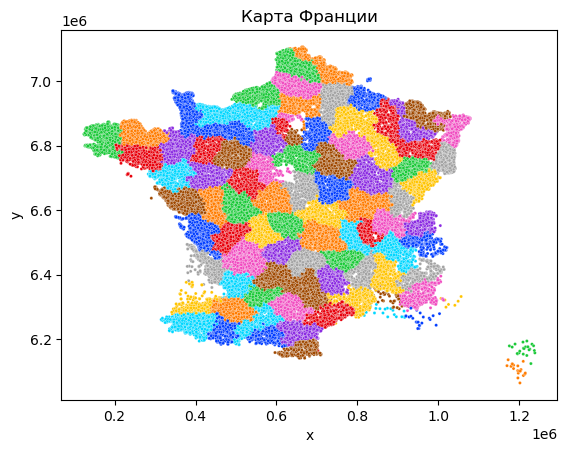

CPU times: total: 7.75 s
Wall time: 8.2 s


In [24]:
%%time

#загрузка модели - дерева решений для определения департамента по координатам поля
with open('./files/tree_department.pkl', 'rb') as pkl_file:
    dep_tree_model = pickle.load(pkl_file)

#загрузка базы
with open('./files/df_all.pkl', 'rb') as pkl_file:
    df_all = pickle.load(pkl_file)

#разметка базы для моделирования
#отбор нужных полей
df_all_for_model = df_all[['x', 'y']].copy()

#разметка
df_all_clusters = dep_tree_model.predict(df_all_for_model)

#присоединение меток департаментов
df_all['DEP_RATTAC'] = df_all_clusters

display(HTML("<style>div.output_scroll {height: 50em;}</style>"))
display(df_all.head(5))

#карта Франции
fig = sns.scatterplot(
    data=df_all[::50],
    x='x',
    y='y',
    hue='DEP_RATTAC',
    palette='bright',
    legend=False,
    s=5
)
fig.set_title('Карта Франции')
plt.show();

Закодируем признаки культур с помощью двоичного кодирования, т.к. категорий растений больше 200. Также закодируем и департаменты, которых под 100, и группы растений.

In [25]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4016476 entries, 0 to 26
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CODE_CULTU      object 
 1   CODE_GROUP      object 
 2   centroid        object 
 3   year_modelling  int64  
 4   type            object 
 5   x               float64
 6   y               float64
 7   cult t-1        object 
 8   gr t-1          int64  
 9   cult t-2        object 
 10  gr t-2          int64  
 11  cult t-3        object 
 12  gr t-3          int64  
 13  cult t-4        object 
 14  gr t-4          int64  
 15  DEP_RATTAC      object 
dtypes: float64(2), int64(5), object(9)
memory usage: 520.9+ MB


In [26]:
%%time

cols = ['cult t-1', 'cult t-2', 'cult t-3', 'cult t-4', 'gr t-1', 'gr t-2', 'gr t-3', 'gr t-4', 'DEP_RATTAC']

#создание кодировщика
bin_encoder = ce.BinaryEncoder(cols=cols)

#применение кодировщика
bin_encoder.fit(df_all[cols])

#выгрузка кодировщика в pickle-файл
with open('./files/bin_encoder.pkl', 'wb') as output:
    pickle.dump(bin_encoder, output)

plants_bin = bin_encoder.transform(df_all[cols])

#добавление результата в базу
df_all = pd.concat([df_all, plants_bin], axis=1)

CPU times: total: 40.7 s
Wall time: 40.7 s


Создадим строку с последовательностью культур через дефис. Еще стоит округлить координаты до десятков или даже сотен, чтобы получить более крупные ячейки и избежать переобучения. Как видно по картам из проекта "Департаменты Франции", для департамента нормальный размах координат - $10^5$.

In [27]:
%%time

#строчка культур
df_all['culture_str'] = df_all['cult t-1'] + '-' + df_all['cult t-2'] + '-' + df_all['cult t-3'] + '-' + df_all['cult t-4']

#округление коордитнатs
df_all['x_round'] = df_all['x'].round(-2)
df_all['y_round'] = df_all['y'].round(-2)

#итоговая база
display(df_all.head(3))

#бинарные переменные которые разметили как int64
long_var_list = [
    'gr t-1_0', 'gr t-1_1', 'gr t-1_2', 'gr t-1_3', 'gr t-1_4',
    'gr t-2_0', 'gr t-2_1', 'gr t-2_2', 'gr t-2_3', 'gr t-2_4',
    'gr t-3_0', 'gr t-3_1', 'gr t-3_2', 'gr t-3_3', 'gr t-3_4',
    'gr t-4_0', 'gr t-4_1', 'gr t-4_2', 'gr t-4_3', 'gr t-4_4',
    'cult t-1_0', 'cult t-1_1', 'cult t-1_2', 'cult t-1_3', 'cult t-1_4',
    'cult t-1_5', 'cult t-1_6', 'cult t-1_7', 'cult t-1_8',
    'cult t-2_0', 'cult t-2_1', 'cult t-2_2', 'cult t-2_3', 'cult t-2_4',
    'cult t-2_5', 'cult t-2_6', 'cult t-2_7', 'cult t-2_8',
    'cult t-3_0', 'cult t-3_1', 'cult t-3_2', 'cult t-3_3', 'cult t-3_4',
    'cult t-3_5', 'cult t-3_6', 'cult t-3_7',
    'cult t-4_0', 'cult t-4_1', 'cult t-4_2', 'cult t-4_3', 'cult t-4_4', 
    'cult t-4_5', 'cult t-4_6', 'cult t-4_7',
    'DEP_RATTAC_0', 'DEP_RATTAC_1', 'DEP_RATTAC_2', 'DEP_RATTAC_3', 'DEP_RATTAC_4', 'DEP_RATTAC_5', 'DEP_RATTAC_6',
]

df_all[long_var_list] = df_all[long_var_list].astype('int8')

print('итоговые характеристики базы:')
print(df_all.info())

#выгрузка базы в pickle-файл
with open('./files/df_all_model.pkl', 'wb') as output:
    pickle.dump(df_all, output)

,CODE_CULTU,CODE_GROUP,centroid,year_modelling,type,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4,DEP_RATTAC,cult t-1_0,cult t-1_1,cult t-1_2,cult t-1_3,cult t-1_4,cult t-1_5,cult t-1_6,cult t-1_7,cult t-1_8,cult t-2_0,cult t-2_1,cult t-2_2,cult t-2_3,cult t-2_4,cult t-2_5,cult t-2_6,cult t-2_7,cult t-2_8,cult t-3_0,cult t-3_1,cult t-3_2,cult t-3_3,cult t-3_4,cult t-3_5,cult t-3_6,cult t-3_7,cult t-4_0,cult t-4_1,cult t-4_2,cult t-4_3,cult t-4_4,cult t-4_5,cult t-4_6,cult t-4_7,gr t-1_0,gr t-1_1,gr t-1_2,gr t-1_3,gr t-1_4,gr t-2_0,gr t-2_1,gr t-2_2,gr t-2_3,gr t-2_4,gr t-3_0,gr t-3_1,gr t-3_2,gr t-3_3,gr t-3_4,gr t-4_0,gr t-4_1,gr t-4_2,gr t-4_3,gr t-4_4,DEP_RATTAC_0,DEP_RATTAC_1,DEP_RATTAC_2,DEP_RATTAC_3,DEP_RATTAC_4,DEP_RATTAC_5,DEP_RATTAC_6,culture_str,x_round,y_round
0,BTH,1,Point (700875.35400312 6883182.5138489),2019,modelling,700875.354003,6.883183e+06,BTN,24,BTH,1,BTH,1,BTN,24,077,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,BTN-BTH-BTH-BTN,700900.0,6883200.0
1,MIS,2,Point (694778.65720113 6859704.83777004),2019,modelling,694778.657201,6.859705e+06,BTH,1,BTP,1,BTH,1,BTH,1,077,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,BTH-BTP-BTH-BTH,694800.0,6859700.0
2,J6S,11,Point (694296.76067938 6859456.47459497),2019,modelling,694296.760679,6.859456e+06,J6S,11,J6S,11,J6S,11,J6S,11,077,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,J6S-J6S-J6S-J6S,694300.0,6859500.0


итоговые характеристики базы:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4016476 entries, 0 to 26
Data columns (total 80 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CODE_CULTU      object 
 1   CODE_GROUP      object 
 2   centroid        object 
 3   year_modelling  int64  
 4   type            object 
 5   x               float64
 6   y               float64
 7   cult t-1        object 
 8   gr t-1          int64  
 9   cult t-2        object 
 10  gr t-2          int64  
 11  cult t-3        object 
 12  gr t-3          int64  
 13  cult t-4        object 
 14  gr t-4          int64  
 15  DEP_RATTAC      object 
 16  cult t-1_0      int8   
 17  cult t-1_1      int8   
 18  cult t-1_2      int8   
 19  cult t-1_3      int8   
 20  cult t-1_4      int8   
 21  cult t-1_5      int8   
 22  cult t-1_6      int8   
 23  cult t-1_7      int8   
 24  cult t-1_8      int8   
 25  cult t-2_0      int8   
 26  cult t-2_1      int8   
 27  cult t-2_2      

Посмотрим на виды растений: за 2018 и 2017 годы выделено 9 категорий (суффиксы _0-_8), а далее - 8 (суффиксы _0-_7).

In [28]:
%%time

#подсчет разнообразия культур по годам
print(f"2019 - {df_all[df_all['year_modelling'] == 2019]['CODE_CULTU'].nunique()}")
print(f"2018 - {df_all[df_all['year_modelling'] == 2019]['cult t-1'].nunique()}")
print(f"2017 - {df_all[df_all['year_modelling'] == 2019]['cult t-2'].nunique()}")
print(f"2016 - {df_all[df_all['year_modelling'] == 2019]['cult t-3'].nunique()}")
print(f"2015 - {df_all[df_all['year_modelling'] == 2019]['cult t-4'].nunique()}")

2019 - 227
2018 - 268
2017 - 268
2016 - 252
2015 - 251
CPU times: total: 5.64 s
Wall time: 5.66 s


А вот и ограничение модели - разное количество видов культур по годам. Если какое-то растение выпадет из оборота, то его потом предсказать будет нельзя. Если же это связано с изменением классификатора (как и именение центров участков с 2015 года), то возникают проблемы с историчностью и последовательностью данных, что в принципе не дает что-то моделировать.

In [29]:
#удаление ненужных объектов
del df_2010
del df_2011
del df_2012
del df_2013
del df_2014

del df_train_2015
del df_train_2016
del df_train_2017
del df_train_2018
del df_train_2019

del df_test_2015
del df_test_2016
del df_test_2017
del df_test_2018

del df_test2_2015
del df_test2_2016
del df_test2_2017
del df_test2_2018
del df_test2_2019

del dep_tree_model
del df_all

### 4. Моделирование

Займемся непосредственно процессом моделирования.

Так как в данных для построения 2015-2019 гг нет всех полей (было более 6 млн, а дано 4 млн), то нельзя построить переменных связвнных с окрестностями кокретного поля (непонятно, какие поля по отношению к данному не были взяты). Приходится ограничиться данными о предыдущих культурах на заданном поле, департаментом и координатами для выделения кластеров с каким-то специфическим поведением.

Зададим в качестве меры качества модели accuracy, так как вполне логично определять качество ка кдолю верно указанных культур. Если бы была площадь полей, то можно было бы взвесить по площади.

### 4.1. Наивная модель

Так как культура обычно меняется каждый год, а если не меняется, то это что-то стандартное многолетнее (луга, виноградники), то для наивной модели можно взять в качестве прогноза в год t культуру за t-2, t-3 и t-4. Определим, какой сдвиг по времени даст наибольшее значение accuracy

In [30]:
%%time

#загрузка базы для модели
with open('./files/df_all_model.pkl', 'rb') as pkl_file:
    df_all_model = pickle.load(pkl_file)

CPU times: total: 2.16 s
Wall time: 2.14 s


In [31]:
%%time

#база для модели
df_naive = df_all_model[df_all_model['type'] == 'modelling'].copy()

#прогноз по году t-i, i = 2, 3, 4 и качество наивной модели
for i in range(2, 4 + 1):
    accuracy = metrics.accuracy_score(df_naive['CODE_CULTU'], df_naive[f"cult t-{i}"])
    print(f"accuracy при прогнозе с помощью года - {i} от прогнозируемого: {accuracy * 100:.2f}%")

accuracy при прогнозе с помощью года - 2 от прогнозируемого: 68.87%
accuracy при прогнозе с помощью года - 3 от прогнозируемого: 65.78%
accuracy при прогнозе с помощью года - 4 от прогнозируемого: 63.17%
CPU times: total: 15.1 s
Wall time: 15.1 s


Наивная модель, говорящая, что на поле будет расти культура такая же, какая росла 2 года назад, уже дает accuracy = 68%. Так как далее разнообразие культур было меньше, то и качество прогноза понижается. Так как на прошлый и позапрошлый относительно моделируемого года годы пришлось наибольшее количество культур, то их в 2019 году мы так предсказать просто не можем, что накладывает ограничение на точность прогноза сверху.

Попробуем улучшить наивный прогноз. Для этого возьмем последовательности культур (специально созданное поле culture_str), и для каждой достаточно часто встречающейся последовательности возьмем самую частую культуру, которая встречается после них. Если она будет встречаться в 70 (80, 90, 95)% случаев, то назовем такую культуру и такую последовательность устойчивыми и возьмем культуру за прогноз, а для остальных оставим наивную модель. Ну и проверим, какая вероятность даст самое большое из accuracy.

In [32]:
%%time

#подсчет частот комбинаций
print(df_naive.groupby(by='culture_str')['year_modelling'].count().sort_values(ascending=False))

culture_str
PPH-PPH-PPH-PPH    1067701
VRC-VRC-VRC-VRC     181790
J6S-J6S-J6S-J6S      99680
SNE-SNE-SNE-SNE      85720
PRL-PRL-PRL-PRL      79333
                    ...   
MCR-MCR-MIE-BTP          1
MCR-MCR-MH6-SOJ          1
MCR-MCR-MH6-PPH          1
MCR-MCR-MH6-LEC          1
XFE-XFE-XFE-XFE          1
Name: year_modelling, Length: 139708, dtype: int64
CPU times: total: 438 ms
Wall time: 441 ms


Сразу видны неменяющиеся последовательности, в т.ч. луга, виноградники и незасеянные поля (Jachère de 6 ans ou plus déclarée comme Surface d intérêt écologique).

In [33]:
%%time

#список комбинаций
df_comb_list = df_naive.groupby(by='culture_str')['year_modelling'].count().sort_values(ascending=False).to_frame()

print(f"всего последовательностей {df_comb_list.shape[0]}.")

#сколько комбинаций, которые встречались свыше заданной частоты
for size in (100, 500, 1000, 5000, 10000, 100000):
    print(f"последовательностей свыше {size} раз: {df_comb_list[df_comb_list['year_modelling'] > size].shape[0]}.")

всего последовательностей 139708.
последовательностей свыше 100 раз: 1846.
последовательностей свыше 500 раз: 452.
последовательностей свыше 1000 раз: 222.
последовательностей свыше 5000 раз: 49.
последовательностей свыше 10000 раз: 27.
последовательностей свыше 100000 раз: 2.
CPU times: total: 438 ms
Wall time: 446 ms


In [34]:
%%time

#отбор последовательностей с частотой больше 100
df_comb_list = df_comb_list[(df_comb_list['year_modelling'] > 100)].copy()

#словарь комбинаций:
#culture_str - комбинация культур, count - ее частота, 
#main_culture - самая частая культура после нее, part - ее доля
dict_combs = {'combination': [], 'count': [], 'main_culture': [], 'part_main': []}

#база для моделирования - для комбинации наивной модели и устойчивых культур
df_naive_comb = df_all_model[df_all_model['type'] == 'modelling'].copy()

for i, combination in enumerate(df_comb_list.index):
    #частота данной комбинации
    count = df_comb_list['year_modelling'].iloc[i]
    
    #частота самого частого варианта культуры после заданной последовательности
    part_main = df_naive_comb[df_naive_comb['culture_str'] == combination]['CODE_CULTU'].value_counts(normalize=True)[0]

    #самый частый вариант
    main_culture = df_naive_comb[df_naive_comb['culture_str'] == combination]['CODE_CULTU'].value_counts(
        normalize=True
    ).idxmax()
    
    #записываем в словарь
    dict_combs['combination'].append(combination)
    dict_combs['count'].append(count)
    dict_combs['main_culture'].append(main_culture)
    dict_combs['part_main'].append(part_main)

#dataframe из словаря комбинаций
df_combs = pd.DataFrame.from_dict(dict_combs)

display(df_combs.head(20))

#выгрузка словаря в pickle-файл
#- как словаря
with open('./files/dict_combs.pkl', 'wb') as output:
    pickle.dump(dict_combs, output)

#- как dataframe
with open('./files/df_combs.pkl', 'wb') as output:
    pickle.dump(df_combs, output)

,combination,count,main_culture,part_main
0,PPH-PPH-PPH-PPH,1067701,PPH,0.991932
1,VRC-VRC-VRC-VRC,181790,VRC,0.986594
2,J6S-J6S-J6S-J6S,99680,J6S,0.962149
3,SNE-SNE-SNE-SNE,85720,SNE,0.975828
4,PRL-PRL-PRL-PRL,79333,PRL,0.957697
5,PTR-PTR-PTR-PTR,70907,PTR,0.770911
6,BTA-BTA-BTA-BTA,67871,BTA,0.970915
7,SPH-SPH-SPH-SPH,56682,SPH,0.986945
8,MIS-MIS-MIS-MIS,53627,MIS,0.849013
9,PRL-PTR-PTR-PTR,41217,PRL,0.903098


CPU times: total: 9min 31s
Wall time: 9min 31s


У лидеров по количеству комбинаций (включая топ - с четвертью наблюдений) - высокая неизменность. Также видно, что для по крайней мере ТОП-10 последовательностей каждый год код культуры один и тот же. Относительно низкая неизменность - менее 80% - у PTR - Autre prairie temporaire de 5 ans ou moins (Другие временные пастбища 5 лет или менее - google.translate) - видимо, все же трудно предсказать, когда луг распашут и засеют. 85% - у MIS: Autre culture non précisée dans la liste (Другая культура, не указанная в списке). Предсказать иное/прочее/другое тоже непросто.

Так как в выборке для предсказания 2019 года - 11% (10%/90%) от выборки для построения, то брать минимальное количество повторений последовательности до 1000 не стоит (за исключением, видимо, последовательностей из 4 одинаковых растений) - там таких последовательностей будет в среднем 9 раз меньше, т.е. устойчивость такой статистики будет под вопросом.

Напишем функцию для прогноза по правилу: 
1) если последовательность культур - ключ в словаре устойчивых последовательностей, то берем культуру по словарю,
2) иначе - культуру по прогнозу модели (будем пытаться каждую модель таким образом улучшить, включая наивную).

При этом для любой (даже нечастой) последовательности из 4 одинаковых растений прогноз будет одинаковым при обоих подходах.

In [35]:
%%time

#функция применения словаря предсказания культуры по предыдущим культурам к базе:
#если есть в словаре, то берем культуру из него, в противном случае - заданный столбец с предсказанием
#(для наивной модели - культуру года t-2)
def model_comb_predict(x):
    '''
    функция прогноза: если последовательность культур - ключ в словаре, то берем культуру по словарю,
                      иначе - культуру года t-2 (как наиболее хороший наивный прогноз)

    Args:
        x - исходная база

    Returns:
        predict - предсказанная культура
        accuracy - флаг для расчета accuracy: 1 - модель предсказала верно, 2 - модель ошиблась

    '''

    if x['culture_str'] in dict_combs:
        predict = dict_combs[x['culture_str']]
    else:
        predict = x['prediction']

    #проверка - угадала модель или нет
    if predict == x['CODE_CULTU']:
        accuracy = 1
    else:
        accuracy = 0

    return predict, accuracy

CPU times: total: 0 ns
Wall time: 0 ns


Построим зависимость качества модели в зависимости от частоты последовательности min_size и минимальной точности предсказания в последовательности min_accuracy.

min_count=1000, min_part_main=0.5 - выполнено
min_count=1000, min_part_main=0.6 - выполнено
min_count=1000, min_part_main=0.7 - выполнено
min_count=1000, min_part_main=0.8 - выполнено
min_count=1000, min_part_main=0.9 - выполнено
min_count=1000, min_part_main=0.95 - выполнено
min_count=5000, min_part_main=0.5 - выполнено
min_count=5000, min_part_main=0.6 - выполнено
min_count=5000, min_part_main=0.7 - выполнено
min_count=5000, min_part_main=0.8 - выполнено
min_count=5000, min_part_main=0.9 - выполнено
min_count=5000, min_part_main=0.95 - выполнено
min_count=10000, min_part_main=0.5 - выполнено
min_count=10000, min_part_main=0.6 - выполнено
min_count=10000, min_part_main=0.7 - выполнено
min_count=10000, min_part_main=0.8 - выполнено
min_count=10000, min_part_main=0.9 - выполнено
min_count=10000, min_part_main=0.95 - выполнено
min_count=100000, min_part_main=0.5 - выполнено
min_count=100000, min_part_main=0.6 - выполнено
min_count=100000, min_part_main=0.7 - выполнено
min_count=100000, m

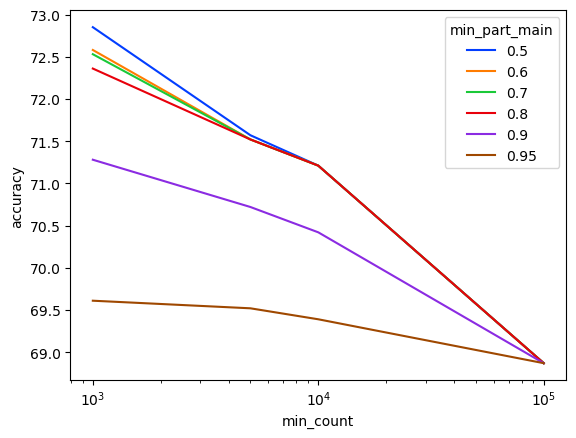

CPU times: total: 17min 42s
Wall time: 17min 43s


In [36]:
%%time

#предсказание по наивной модели
df_naive_comb = df_all_model[df_all_model['type'] == 'modelling'].copy()
df_naive_comb['prediction'] = df_naive_comb['cult t-2']

#загрузка файла с комбинациями
with open('./files/df_combs.pkl', 'rb') as pkl_file:
    df_combs = pickle.load(pkl_file)

#словарь результатов модели - смеси наивной и частотной
dict_result_model = {'min_count': [], 'min_part_main': [], 'accuracy': []}
    
#grid search по частоте последовательности min_size и минимальной точности предсказания в последовательности min_accuracy
for min_count in (1000, 5000, 10000, 100000):
    for min_part_main in (0.5, 0.6, 0.7, 0.8, 0.9, 0.95):

        #искомые комбинации с частотой и долей основной культуры больше минимальных
        df_combs_filtered = df_combs[(df_combs['count'] > min_count) & (df_combs['part_main'] > min_part_main)].copy()
        df_combs_filtered = df_combs_filtered.reset_index()
        
        #словарь последовательностей и самого частого варианта культуры
        dict_combs = {}

        #пополнение словаря последовательностей
        for i in df_combs_filtered.index:
            dict_combs[df_combs_filtered['combination'].iloc[i]] = df_combs_filtered['main_culture'].iloc[i]
            
        #база моделирования
        df_modelling = df_naive_comb.copy()
        
        #применение функции получения комбинации модели и устойчивых последовательностей
        df_modelling[['naive_and_comb', 'accuracy']] = df_modelling.apply(model_comb_predict, axis=1).to_list()

        #пополнение словаря с результатами при данной комбинации параметров
        dict_result_model['min_count'].append(min_count)
        dict_result_model['min_part_main'].append(min_part_main)
        dict_result_model['accuracy'].append((df_modelling[f'accuracy'].mean() * 100).round(2))

        print(f"min_count={min_count}, min_part_main={min_part_main} - выполнено")
        
#словарь - в dataframe для визуализации
df_result_model = pd.DataFrame.from_dict(dict_result_model)

#табличка для визуализации результатов моделирования
print('-----' * 10)
print(df_result_model.pivot(index='min_count', columns='min_part_main', values='accuracy'))
print('-----' * 10)

#визуализация
fig = sns.lineplot(
    data=df_result_model,
    x='min_count',
    y='accuracy',
    hue='min_part_main',
    palette='bright',
)
plt.xscale('log')

plt.show();

Для наивной модели точность получилась почти 69%. Если использовать устойчивые последовательности, то точность поднимется до 73%.

Чем больше мы потребуем минимальную точность для определения устойчивой последовательности, тем ниже качество такой модели. Также оно снижается с ростом минимального количества повторений последовательности. Это логично, т.к. такие условия - ужесточение модели.

In [37]:
#сохранение словарей
min_count = 1000

for min_part_main in (50, 60, 70, 80, 90, 95):
    #словарь последовательностей и самого частого варианта культуры
    dict_combs = {}

    for i in df_combs_filtered.index:
        dict_combs[df_combs_filtered['combination'].iloc[i]] = df_combs_filtered['main_culture'].iloc[i]
    
    #выгрузка словаря в pickle-файл
    with open(f"./files/dict_combs_accuracy_{min_part_main}.pkl", 'wb') as output:
        pickle.dump(dict_combs, output)

del df_naive_comb

### 4.2. Дерево решений

In [38]:
%%time

#загрузка базы для модели
with open('./files/df_all_model.pkl', 'rb') as pkl_file:
    df_all_model = pickle.load(pkl_file)
    
#список переменных для моделирования
var_list = [
    'gr t-1_0', 'gr t-1_1', 'gr t-1_2', 'gr t-1_3', 'gr t-1_4',
    'gr t-2_0', 'gr t-2_1', 'gr t-2_2', 'gr t-2_3', 'gr t-2_4',
    'gr t-3_0', 'gr t-3_1', 'gr t-3_2', 'gr t-3_3', 'gr t-3_4',
    'gr t-4_0', 'gr t-4_1', 'gr t-4_2', 'gr t-4_3', 'gr t-4_4',
    'cult t-1_0', 'cult t-1_1', 'cult t-1_2', 'cult t-1_3', 'cult t-1_4',
    'cult t-1_5', 'cult t-1_6', 'cult t-1_7', 'cult t-1_8',
    'cult t-2_0', 'cult t-2_1', 'cult t-2_2', 'cult t-2_3', 'cult t-2_4',
    'cult t-2_5', 'cult t-2_6', 'cult t-2_7', 'cult t-2_8',
    'cult t-3_0', 'cult t-3_1', 'cult t-3_2', 'cult t-3_3', 'cult t-3_4',
    'cult t-3_5', 'cult t-3_6', 'cult t-3_7',
    'cult t-4_0', 'cult t-4_1', 'cult t-4_2', 'cult t-4_3', 'cult t-4_4', 
    'cult t-4_5', 'cult t-4_6', 'cult t-4_7',
    'DEP_RATTAC_0', 'DEP_RATTAC_1', 'DEP_RATTAC_2', 'DEP_RATTAC_3', 'DEP_RATTAC_4', 'DEP_RATTAC_5', 'DEP_RATTAC_6',
    'x_round', 'y_round'
]

target = 'CODE_CULTU'

#выборка для построения
X = df_all_model[df_all_model['type'] == 'modelling'][var_list]

#целевая переменная
y = df_all_model[df_all_model['type'] == 'modelling'][target]

#train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_random, test_size=0.2)

CPU times: total: 7.11 s
Wall time: 7.39 s


In [39]:
%%time

#параметры поиска
param_grid = {
    'min_samples_leaf': [i for i in range(7, 10 + 1)], #изначально был параметр (5, 10+1), но выбирается-то все равно 10
    'max_depth': [i for i in range(15, 20 + 1)],
}

#поиск наилучших параметров
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=my_random), 
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=4,
    verbose=2
)

grid_search_tree.fit(X_train, y_train) 
print(f"accuracy на тестовом наборе: {grid_search_tree.score(X_test, y_test) * 100:.2f}%")
y_test_pred = grid_search_tree.predict(X_test)
print(f"Наилучшие значения гиперпараметров: {grid_search_tree.best_params_}")

#выгрузка grid search в pickle-файл
with open('./files/grid_search_tree.pkl', 'wb') as output:
    pickle.dump(grid_search_tree, output)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


accuracy на тестовом наборе: 81.16%
Наилучшие значения гиперпараметров: {'max_depth': 18, 'min_samples_leaf': 10}
CPU times: total: 1min 28s
Wall time: 41min 43s


Оптимальным признано дерево с глубиной 18 и минимальным размером листа 10. Применим данные параметры и исследуем качество.

In [40]:
%%time

#загрузка модели - grid_search_tree
with open('./files/grid_search_tree.pkl', 'rb') as pkl_file:
    grid_search_tree = pickle.load(pkl_file)

#исходное дерево
tree_model=tree.DecisionTreeClassifier(
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf'],
    max_depth=grid_search_tree.best_params_['max_depth'],
    random_state=my_random
)

#построение модели
tree_model.fit(X_train, y_train)

#качество
# на train
y_train_pred = tree_model.predict(X_train)
print(f"accuracy на Train: {metrics.accuracy_score(y_train, y_train_pred) * 100:.2f}%")

#на test
y_test_pred = tree_model.predict(X_test)
print(f"accuracy на тестовом наборе: {metrics.accuracy_score(y_test, y_test_pred) * 100:.2f}%")

#выгрузка модели в pickle-файл
with open('./files/tree_model.pkl', 'wb') as output:
    pickle.dump(tree_model, output)

accuracy на Train: 82.50%
accuracy на тестовом наборе: 81.16%
CPU times: total: 1min 10s
Wall time: 1min 10s


Модель действительно является относительно сбалансировнной, не сильно переобученной - разница tran и test - около 1.3%.

Добавим к ней устойчивые последовательности и максимизируем accuracy на test с их учетом. Должно быть хуже, чем без, т.к. элементарные повторения последовательность дерево должно их находить. Но посмотрим, как сильно упадет качество - если бы мы, убедившись в устойчивости последовательностей, исключили бы их из моделирования, чтобы снизить вычислительную нагрузку (одни постоянные луга с accuracy=99% - это четверть наблюдений), что довольно значимо для небольших вычислительных мощностей.

In [41]:
%%time

#создание базы с разметкой train/test и предсказанными по модели значениями
def final_base(train_base, test_base, y_train_predict, y_test_predict):
    '''
    функция создания базы с разметкой train/test и предсказанными по моделям значениями
    Args:
        train_base - база для построения
        test_base - база для теста
        y_train_predict - вектор с предсказаниями на базе для построения
        y_test_predict - вектор с предсказаниями на базе для теста
    '''
    
    #разметка
    train_base['prediction'] = y_train_predict
    test_base['prediction'] = y_test_predict
    
    #флаг train/test
    train_base['train'] = 1
    test_base['train'] = 0
    
    final_base = pd.concat([train_base, test_base], axis=0)

    return final_base

df_tree_model_comb = final_base(
    train_base=X_train,
    test_base=X_test,
    y_train_predict=y_train_pred,
    y_test_predict=y_test_pred
)

#добавление культуры
df_tree_model_comb['CODE_CULTU'] = pd.concat([y_train, y_test], axis=0)

#добавление последвательности культур
df_tree_model_comb = df_tree_model_comb.join(df_all_model[['culture_str']], how='inner')

#загрузка файла с комбинациями
with open('./files/df_combs.pkl', 'rb') as pkl_file:
    df_combs = pickle.load(pkl_file)

#словарь результатов модели - смеси наивной и частотной
dict_result_model = {'min_part_main': [], 'accuracy': []}
    
#grid search по частоте последовательности min_size и минимальной точности предсказания в последовательности min_accuracy
for min_part_main in (0.5, 0.6, 0.7, 0.8, 0.9, 0.95):

    #искомые комбинации с частотой и долей основной культуры больше минимальных
    df_combs_filtered = df_combs[df_combs['part_main'] > min_part_main].copy()
    df_combs_filtered = df_combs_filtered.reset_index()
        
    #словарь последовательностей и самого частого варианта культуры
    dict_combs = {}

    #пополнение словаря последовательностей
    for i in df_combs_filtered.index:
        dict_combs[df_combs_filtered['combination'].iloc[i]] = df_combs_filtered['main_culture'].iloc[i]
            
    #база моделирования
    df_modelling = df_tree_model_comb.copy()
        
    #применение функции получения комбинации модели и устойчивых последовательностей
    df_modelling[['naive_and_comb', 'accuracy']] = df_modelling.apply(model_comb_predict, axis=1).to_list()

    #пополнение словаря с результатами при данной комбинации параметров
    dict_result_model['min_part_main'].append(min_part_main)
    dict_result_model['accuracy'].append((df_modelling[f'accuracy'].mean() * 100).round(2))

    print(f"min_part_main={min_part_main} - выполнено")

#словарь - в dataframe
df_result_model = pd.DataFrame.from_dict(dict_result_model)

print('-----' * 10)
print('accuracy при комбинации дерева и устойчивых последовательностей')
print(df_result_model)

min_part_main=0.5 - выполнено
min_part_main=0.6 - выполнено
min_part_main=0.7 - выполнено
min_part_main=0.8 - выполнено
min_part_main=0.9 - выполнено
min_part_main=0.95 - выполнено
--------------------------------------------------
accuracy при комбинации дерева и устойчивых последовательностей
   min_part_main  accuracy
0           0.50     76.71
1           0.60     76.98
2           0.70     77.23
3           0.80     77.63
4           0.90     78.06
5           0.95     78.46
CPU times: total: 4min 28s
Wall time: 4min 31s


Accuracy меньше, чем у дерева, как и ожидалось. Даже для последовательностей растений, когда 4 года был один и тот же вид, дереву удаолсь предсказать следующую культуру точнее.

Посмотрим на вклад переменных в дереве.

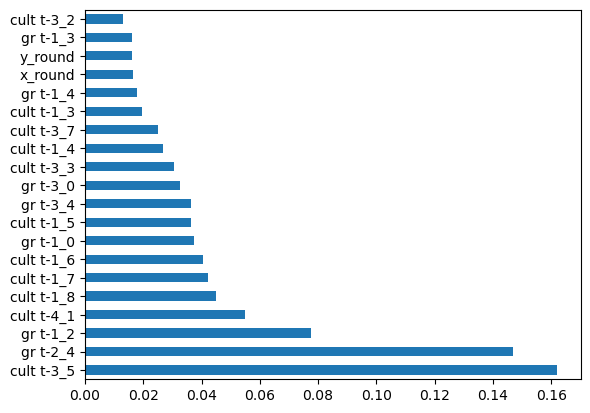

In [42]:
#вклад переменных
feat_importances = pd.Series(tree_model.feature_importances_, index=var_list)

#график
feat_importances.nlargest(20).plot(kind='barh')
plt.show();

Интересно, что самые значимые параметры - культуры и группы культур в предшествующие годы, и только потом координаты. А департаменты вообще не вошли в топ-20, так как департамент - это в целом производная координат, и если что-то в некоторой точке и ее окрестностях распространено или, наоборот, не сажалось, то и неважно, какой это департамент.

### 4.3. Случайный лес

In [43]:
%%time

#загрузка базы для модели
with open('./files/df_all_model.pkl', 'rb') as pkl_file:
    df_all_model = pickle.load(pkl_file)

#список переменных для моделирования
var_list = [
    'gr t-1_0', 'gr t-1_1', 'gr t-1_2', 'gr t-1_3', 'gr t-1_4',
    'gr t-2_0', 'gr t-2_1', 'gr t-2_2', 'gr t-2_3', 'gr t-2_4',
    'gr t-3_0', 'gr t-3_1', 'gr t-3_2', 'gr t-3_3', 'gr t-3_4',
    'gr t-4_0', 'gr t-4_1', 'gr t-4_2', 'gr t-4_3', 'gr t-4_4',
    'cult t-1_0', 'cult t-1_1', 'cult t-1_2', 'cult t-1_3', 'cult t-1_4',
    'cult t-1_5', 'cult t-1_6', 'cult t-1_7', 'cult t-1_8',
    'cult t-2_0', 'cult t-2_1', 'cult t-2_2', 'cult t-2_3', 'cult t-2_4',
    'cult t-2_5', 'cult t-2_6', 'cult t-2_7', 'cult t-2_8',
    'cult t-3_0', 'cult t-3_1', 'cult t-3_2', 'cult t-3_3', 'cult t-3_4',
    'cult t-3_5', 'cult t-3_6', 'cult t-3_7',
    'cult t-4_0', 'cult t-4_1', 'cult t-4_2', 'cult t-4_3', 'cult t-4_4', 
    'cult t-4_5', 'cult t-4_6', 'cult t-4_7',
    'DEP_RATTAC_0', 'DEP_RATTAC_1', 'DEP_RATTAC_2', 'DEP_RATTAC_3', 'DEP_RATTAC_4', 'DEP_RATTAC_5', 'DEP_RATTAC_6',
    'x_round', 'y_round'
]

target = 'CODE_CULTU'

#выборка для построения
X = df_all_model[df_all_model['type'] == 'modelling'][var_list]

#целевая переменная
y = df_all_model[df_all_model['type'] == 'modelling'][target]

#train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_random, test_size=0.2)

CPU times: total: 6.75 s
Wall time: 6.96 s


In [44]:
%%time

#построение модели, анализ зависимости качества от количества деревьев
#параметры деревьев возьмем из оптимальных параметров для одного дерева из grid_search_tree
with open('./files/grid_search_tree.pkl', 'rb') as pkl_file:
    grid_search_tree = pickle.load(pkl_file)

#цикл по количеству деревьев в лесу от 150 до 25 с шагом 25
for n_estimators in [i * 25 for i in range(6, 1 - 1, -1)]:
    #настройка леса
    rand_forest = RandomForestClassifier(
        min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf'],
        max_depth=grid_search_tree.best_params_['max_depth'],
        n_estimators=n_estimators,
        random_state=my_random,
        n_jobs=4
    )

    #построение случайного леса
    rand_forest.fit(X_train, y_train)

    #предсказание
    y_test_pred = rand_forest.predict(X_test)
    
    #качество
    print(f"accuracy на тесте при n_estimators={n_estimators}: {metrics.accuracy_score(y_test, y_test_pred) * 100:.2f}%")

accuracy на тесте при n_estimators=150: 81.71%
accuracy на тесте при n_estimators=125: 81.70%
accuracy на тесте при n_estimators=100: 81.70%
accuracy на тесте при n_estimators=75: 81.68%
accuracy на тесте при n_estimators=50: 81.67%
accuracy на тесте при n_estimators=25: 81.64%
CPU times: total: 1h 40min 12s
Wall time: 26min 50s


Случайный лес поднимает accuracy на тесте на 0.5% до 81.7%. При этом достаточно уже 50 деревьев, после чего начинаются мизерные приросты точности. Сохраним модель на 100 деревьях.

In [45]:
%%time

with open('./files/grid_search_tree.pkl', 'rb') as pkl_file:
    grid_search_tree = pickle.load(pkl_file)

#модель на 100 деревьев
n_estimators=100
rand_forest = RandomForestClassifier(
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf'],
    max_depth=grid_search_tree.best_params_['max_depth'],
    n_estimators=n_estimators,
    random_state=my_random,
    n_jobs=4
)

#построение случайного леса
rand_forest.fit(X_train, y_train)

#выгрузка модели в pickle-файл
with open('./files/rand_forest_model.pkl', 'wb') as output:
    pickle.dump(rand_forest, output)

CPU times: total: 15min 12s
Wall time: 3min 59s


In [46]:
%%time

#загрузка модели случайного леса
with open('./files/rand_forest_model.pkl', 'rb') as pkl_file:
    rand_forest = pickle.load(pkl_file)

#предсказание на train
y_test_pred = rand_forest.predict(X_test)

#качество
print(f"accuracy на тесте при n_estimators={n_estimators}: {metrics.accuracy_score(y_test, y_test_pred) * 100:.2f}%")

#предсказание на train. почему-то расчет по всей базе зависает, поэтому порциями по 500000
i = 0
while i < X_train.shape[0] / 500000:
    #счетчик
    i = i + 1

    #предсказание на порции 500000 записей
    y_train_pred_tmp = rand_forest.predict(X_train[(i - 1) * 500000: i * 500000])

    #соединение
    if i == 1:
        y_train_pred = y_train_pred_tmp.copy()
    else:
        y_train_pred = np.concatenate([y_train_pred, y_train_pred_tmp], axis=0)

    #отметка об обработке порции
    print(f"{(i - 1) * 500000, min(i * 500000, X_train.shape[0])} done")

#качество на train
print(f"accuracy на train при n_estimators={n_estimators}: {metrics.accuracy_score(y_train, y_train_pred) * 100:.2f}%")

accuracy на тесте при n_estimators=100: 81.70%
(0, 500000) done
(500000, 1000000) done
(1000000, 1500000) done
(1500000, 2000000) done
(2000000, 2500000) done
(2500000, 2891843) done
accuracy на train при n_estimators=100: 82.40%
CPU times: total: 18min 15s
Wall time: 5min 35s


Лес помог снизить разницу между train и test: 82.40% - 81.70% = 0.7% (на дереве было 1.3%).  
Посмотрим на значимость переменных.

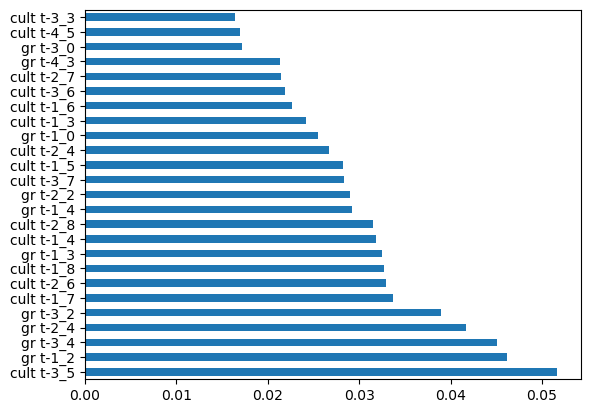

In [47]:
#вклад переменных
feat_importances = pd.Series(rand_forest.feature_importances_, index=var_list)

#график
feat_importances.nlargest(25).plot(kind='barh')
plt.show();

#удаление ненужных объектов
del rand_forest

Наиболее значимыми переменными снова оказались растения и группы растений за предыдущие годы. Вес переменных стал более сбалансированным, убывние идет плавнее.

Соберем базу с предсказаниями с добавлением департамента и последовательности растений.

In [48]:
#предсказания
y_forest_pred = np.concatenate((y_train_pred, y_test_pred))

#факт
y_forest_dep = pd.concat([y_train, y_test]).to_frame()

#соединение и сортировка
y_forest_dep['forest_predict'] = y_forest_pred
y_forest_dep = y_forest_dep.sort_index()

#добавление департамента и последовательности растений
y_forest_dep[['DEP_RATTAC', 'culture_str']] = df_all_model[df_all_model['type'] == 'modelling'][['DEP_RATTAC', 'culture_str']]

#запись в pickle-файл
with open('./files/y_forest_dep.pkl', 'wb') as output:
    pickle.dump(y_forest_dep, output)

### 4.4. Бустинг

In [49]:
%%time

#загрузка базы для модели
with open('./files/df_all_model.pkl', 'rb') as pkl_file:
    df_all_model = pickle.load(pkl_file)

#загрузка базы с разметкой по модели случайного леса, кодом департамента и последовательностью растений
with open('./files/y_forest_dep.pkl', 'rb') as pkl_file:
    y_forest_dep = pickle.load(pkl_file)

#список переменных для моделирования
var_list = [
    'gr t-1_0', 'gr t-1_1', 'gr t-1_2', 'gr t-1_3', 'gr t-1_4',
    'gr t-2_0', 'gr t-2_1', 'gr t-2_2', 'gr t-2_3', 'gr t-2_4',
    'gr t-3_0', 'gr t-3_1', 'gr t-3_2', 'gr t-3_3', 'gr t-3_4',
    'gr t-4_0', 'gr t-4_1', 'gr t-4_2', 'gr t-4_3', 'gr t-4_4',
    'cult t-1_0', 'cult t-1_1', 'cult t-1_2', 'cult t-1_3', 'cult t-1_4',
    'cult t-1_5', 'cult t-1_6', 'cult t-1_7', 'cult t-1_8',
    'cult t-2_0', 'cult t-2_1', 'cult t-2_2', 'cult t-2_3', 'cult t-2_4',
    'cult t-2_5', 'cult t-2_6', 'cult t-2_7', 'cult t-2_8',
    'cult t-3_0', 'cult t-3_1', 'cult t-3_2', 'cult t-3_3', 'cult t-3_4',
    'cult t-3_5', 'cult t-3_6', 'cult t-3_7',
    'cult t-4_0', 'cult t-4_1', 'cult t-4_2', 'cult t-4_3', 'cult t-4_4', 
    'cult t-4_5', 'cult t-4_6', 'cult t-4_7',
    'DEP_RATTAC_0', 'DEP_RATTAC_1', 'DEP_RATTAC_2', 'DEP_RATTAC_3', 'DEP_RATTAC_4', 'DEP_RATTAC_5', 'DEP_RATTAC_6',
    'x_round', 'y_round'
]

target = 'CODE_CULTU'

#выборка для построения
X = df_all_model[df_all_model['type'] == 'modelling'][var_list + ['culture_str'] + ['DEP_RATTAC']]

#целевая переменная
y = df_all_model[df_all_model['type'] == 'modelling'][target]

#train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_random, test_size=0.2)

CPU times: total: 7.91 s
Wall time: 8.37 s


Так как бустинг - довольно долгая процедура, а последовательности из 4 одинаковых растений (особенно PPH-PPH-PPH-PPH) мы предсказываем довольно неплохо, то исключим их из построения. Исключаем после деления на train/test, чтобы деление оставалось такое же, как и в предыдущих моделях для сравнимости результатов.

Построим модель на случайном дпартаменте. Случайным стал 77 департамент (Се́на и Ма́рна (фр. Seine-et-Marne) — департамент Франции, один из департаментов региона Иль-де-Франс).

In [50]:
%%time

#пример на 1 департаменте
department = '077'

#переменные для удаления из X
del_vars = ['CODE_CULTU', 'DEP_RATTAC', 'culture_str']

#соедидиняем X и y, удаляем 'PPH-PPH-PPH-PPH'
#для train
X_y_train_clear = pd.concat([X_train, y_train], axis = 1)
X_y_train_clear = X_y_train_clear[X_y_train_clear['culture_str'] != 'PPH-PPH-PPH-PPH']

#для test
X_y_test_clear = pd.concat([X_test, y_test], axis = 1)
X_y_test_clear = X_y_test_clear[X_y_test_clear['culture_str'] != 'PPH-PPH-PPH-PPH']

print(f"всего в базе было {pd.concat([X_train, y_train], axis = 1).shape[0]} строк, стало {X_y_train_clear.shape[0]} строк")

#обратное деление на train/test, удаление лишних столбцов, выделение департамента
X_train_clear = X_y_train_clear[X_y_train_clear['DEP_RATTAC'] == department].drop(columns=del_vars)
y_train_clear = X_y_train_clear[X_y_train_clear['DEP_RATTAC'] == department]['CODE_CULTU']

X_test_clear = X_y_test_clear[X_y_test_clear['DEP_RATTAC'] == department].drop(columns=del_vars)
y_test_clear = X_y_test_clear[X_y_test_clear['DEP_RATTAC'] == department]['CODE_CULTU']

print(f"департамент {department}. наблюдений: {X_train_clear.shape[0]} ")
#задание параметров модели
boost_model = CatBoostClassifier(
    #task_type='GPU', - быстрее в 10 раз, но результаты невоспроизводимы:
    #https://catboost.ai/en/docs/features/training-on-gpu - Training on GPU is non-deterministic
    loss_function='MultiClass',
    random_seed=my_random,
    max_depth=9,
    thread_count=12,
    iterations=250,
)

#построение модели
boost_model.fit(
    X_train_clear,
    y_train_clear,
    verbose=10
)

#качество модели
y_train_pred = boost_model.predict(X_train_clear)
y_test_pred = boost_model.predict(X_test_clear)
print(f"accuracy на train: {metrics.accuracy_score(y_train_pred, y_train_clear) * 100:.2f}%")
print(f"accuracy на test: {metrics.accuracy_score(y_test_pred, y_test_clear) * 100:.2f}%")

#качество леса на данном департаменте по всем наблюдениям (train и test), кроме culture_str = 'PPH-PPH-PPH-PPH'
#на test качество будет ниже, но если бустинг дает качество на тесте больше, чем лес на всей выборке, то это еще лучше
y_ = y_forest_dep[(y_forest_dep['DEP_RATTAC'] == department) & (y_forest_dep['culture_str'] != 'PPH-PPH-PPH-PPH')]
print(f"accuracy случайного леса: {metrics.accuracy_score(y_['CODE_CULTU'], y_['forest_predict']) * 100:.2f}%")

print('-----' * 10)

del X_y_train_clear
del X_y_test_clear

del X_train_clear
del y_train_clear
del X_test_clear
del y_test_clear
del y_train_pred
del y_test_pred
del y_

всего в базе было 2891843 строк, стало 2037431 строк
департамент 077. наблюдений: 20072 
Learning rate set to 0.297506
0:	learn: 2.0357611	total: 1.31s	remaining: 5m 25s
10:	learn: 1.0930703	total: 13s	remaining: 4m 43s
20:	learn: 0.9388521	total: 24.7s	remaining: 4m 29s
30:	learn: 0.8470537	total: 36s	remaining: 4m 14s
40:	learn: 0.7862491	total: 47.7s	remaining: 4m 3s
50:	learn: 0.7283609	total: 59.9s	remaining: 3m 53s
60:	learn: 0.6803466	total: 1m 11s	remaining: 3m 42s
70:	learn: 0.6364737	total: 1m 23s	remaining: 3m 30s
80:	learn: 0.6023907	total: 1m 35s	remaining: 3m 19s
90:	learn: 0.5720721	total: 1m 47s	remaining: 3m 7s
100:	learn: 0.5424222	total: 1m 59s	remaining: 2m 56s
110:	learn: 0.5187156	total: 2m 11s	remaining: 2m 44s
120:	learn: 0.4978515	total: 2m 23s	remaining: 2m 32s
130:	learn: 0.4769735	total: 2m 35s	remaining: 2m 20s
140:	learn: 0.4588061	total: 2m 47s	remaining: 2m 9s
150:	learn: 0.4405912	total: 2m 59s	remaining: 1m 57s
160:	learn: 0.4271043	total: 3m 11s	remai

Были подобраны параметры обучения, которые поднимают качество, и при этом модель считается за приемлемое (10-15 минут) время. На случайно выбранном департаменте наблюдается рост качества на более чем 3% по участкам, не являющимся лугами.

При увеличении параметра depth качество растет, но и время тоже. Также рост будет при увеличении iterations. Но тогда время будет совсем большим. На видеокарте, как отмечено в комментариях кода, расчет будет гораздо быстрее, но каждый раз с новым результатом.

Построим модели по департаметам в отдельном проекте "3. Модели CatBoost.ipynb". В результате для каждого департамента создастся файл boost_dep_<i\>.pkl с моделью и  файл calc_dep_<i\>.pkl с рассчитанным предсказанием по модели (i - код департамента).

In [51]:
#список департаментов
department_list = X['DEP_RATTAC'].unique()
department_list.sort()
print(f"всего департаментов {len(department_list)}")
print(department_list)

#все результаты в 1 базу
for i, department in enumerate(department_list):
    with open('./boosting/calc_dep_' + department + '.pkl', 'rb') as pkl_file:
        calc_base = pickle.load(pkl_file)
        
    if i == 0:
        final_boost_model = calc_base.copy()
    else:
        final_boost_model = pd.concat([final_boost_model, calc_base], axis=0)

display(final_boost_model.head(5))

всего департаментов 93
['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '021' '022' '023' '024' '025'
 '026' '027' '028' '029' '02A' '02B' '030' '031' '032' '033' '034' '035'
 '036' '037' '038' '039' '040' '041' '042' '043' '044' '045' '046' '047'
 '048' '049' '050' '051' '052' '053' '054' '055' '056' '057' '058' '059'
 '060' '061' '062' '063' '064' '065' '066' '067' '068' '069' '070' '071'
 '072' '073' '074' '076' '077' '078' '079' '080' '081' '082' '083' '084'
 '085' '086' '087' '088' '089' '090' '091' '094' '095']


,train,PPH,CODE_CULTU,predict_boost,predict_final
254804,1,0,BTA,BTA,BTA
3050825,1,0,ORH,MIS,MIS
3059854,1,0,MIE,MIE,MIE
3049240,1,1,PPH,PPH,PPH
3071707,1,0,BTH,BTH,BTH


In [52]:
#качество модели (с учетом последовательности PPH-PPH-PPH-PPH)
print(f"""accuracy бустинга на train: {metrics.accuracy_score(
    final_boost_model[final_boost_model['train'] == 1]['CODE_CULTU'],
    final_boost_model[final_boost_model['train'] == 1]['predict_final']
) * 100:.2f}%""")

print(f"""accuracy бустинга на test: {metrics.accuracy_score(
    final_boost_model[final_boost_model['train'] == 0]['CODE_CULTU'],
    final_boost_model[final_boost_model['train'] == 0]['predict_final']
) * 100:.2f}%""")

accuracy бустинга на train: 92.80%
accuracy бустинга на test: 82.32%


В итоге прирост accuracy на тесте составил 0.6% (с 81.7 до 82.3). На train, само собой, переобучение.  
При росте количества итераций до 1000 по умолчанию и при построении дерева на максимальную глубину качество, видимо, поднимется еще.

### 5. Итоги

Пусть есть база из полей с культурами и типами культур за последние 4 года. Тогда необходимо:

1) Присвоить каждому полю "модельный" департамент с помощью дерева решений tree_department.pkl)
2) Закодировать все текстовые признаки c помощью кодировщика bin_encoder.pkl
3) Разбить координаты поля на x и y и округлить их до 100
4) Создать строку культур за 4 года

И в итоге привести к следующему формату:

In [53]:
%%time

#загрузка базы для моделирования и прогноза
with open('./files/df_all_model.pkl', 'rb') as pkl_file:
    df_all_model = pickle.load(pkl_file)

#выделение базы для прогноза 2019 года
df_2019_predict = df_all_model[(df_all_model['year_modelling'] == 2019) & (df_all_model['type'] == 'predict2019')]
df_2019_predict = df_2019_predict.drop(columns=['CODE_CULTU', 'CODE_GROUP', 'year_modelling', 'type'])
print('2019:')
display(df_2019_predict.head(3))
print('-----' * 10)

#выделение базы для прогноза 2020 года
df_2020_predict = df_all_model[(df_all_model['year_modelling'] == 2020) & (df_all_model['type'] == 'predict2020')]
df_2020_predict = df_2020_predict.drop(columns=['CODE_CULTU', 'CODE_GROUP', 'year_modelling', 'type'])
print('2020:')
display(df_2020_predict.head(3))

2019:


,centroid,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4,DEP_RATTAC,cult t-1_0,cult t-1_1,cult t-1_2,cult t-1_3,cult t-1_4,cult t-1_5,cult t-1_6,cult t-1_7,cult t-1_8,cult t-2_0,cult t-2_1,cult t-2_2,cult t-2_3,cult t-2_4,cult t-2_5,cult t-2_6,cult t-2_7,cult t-2_8,cult t-3_0,cult t-3_1,cult t-3_2,cult t-3_3,cult t-3_4,cult t-3_5,cult t-3_6,cult t-3_7,cult t-4_0,cult t-4_1,cult t-4_2,cult t-4_3,cult t-4_4,cult t-4_5,cult t-4_6,cult t-4_7,gr t-1_0,gr t-1_1,gr t-1_2,gr t-1_3,gr t-1_4,gr t-2_0,gr t-2_1,gr t-2_2,gr t-2_3,gr t-2_4,gr t-3_0,gr t-3_1,gr t-3_2,gr t-3_3,gr t-3_4,gr t-4_0,gr t-4_1,gr t-4_2,gr t-4_3,gr t-4_4,DEP_RATTAC_0,DEP_RATTAC_1,DEP_RATTAC_2,DEP_RATTAC_3,DEP_RATTAC_4,DEP_RATTAC_5,DEP_RATTAC_6,culture_str,x_round,y_round
0,Point (837113.21815327 6542642.03294466),837113.218153,6.542642e+06,J6S,11,J6S,11,J6S,11,J6S,11,001,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,J6S-J6S-J6S-J6S,837100.0,6542600.0
1,Point (859951.6897682 6548701.23025595),859951.689768,6.548701e+06,PTR,19,PTR,19,PTR,19,BTH,1,001,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,PTR-PTR-PTR-BTH,860000.0,6548700.0
2,Point (869152.69888415 6554341.41204209),869152.698884,6.554341e+06,BTH,1,MIS,2,MIS,2,BTH,1,001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,BTH-MIS-MIS-BTH,869200.0,6554300.0


--------------------------------------------------
2020:


,centroid,x,y,cult t-1,gr t-1,cult t-2,gr t-2,cult t-3,gr t-3,cult t-4,gr t-4,DEP_RATTAC,cult t-1_0,cult t-1_1,cult t-1_2,cult t-1_3,cult t-1_4,cult t-1_5,cult t-1_6,cult t-1_7,cult t-1_8,cult t-2_0,cult t-2_1,cult t-2_2,cult t-2_3,cult t-2_4,cult t-2_5,cult t-2_6,cult t-2_7,cult t-2_8,cult t-3_0,cult t-3_1,cult t-3_2,cult t-3_3,cult t-3_4,cult t-3_5,cult t-3_6,cult t-3_7,cult t-4_0,cult t-4_1,cult t-4_2,cult t-4_3,cult t-4_4,cult t-4_5,cult t-4_6,cult t-4_7,gr t-1_0,gr t-1_1,gr t-1_2,gr t-1_3,gr t-1_4,gr t-2_0,gr t-2_1,gr t-2_2,gr t-2_3,gr t-2_4,gr t-3_0,gr t-3_1,gr t-3_2,gr t-3_3,gr t-3_4,gr t-4_0,gr t-4_1,gr t-4_2,gr t-4_3,gr t-4_4,DEP_RATTAC_0,DEP_RATTAC_1,DEP_RATTAC_2,DEP_RATTAC_3,DEP_RATTAC_4,DEP_RATTAC_5,DEP_RATTAC_6,culture_str,x_round,y_round
0,Point (625771.91344838 7090455.27713006),625771.913448,7.090455e+06,BTH,1,PTC,25,BTH,1,BTN,24,062,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,BTH-PTC-BTH-BTN,625800.0,7090500.0
1,Point (628059.94205405 7090942.4387415),628059.942054,7.090942e+06,ORP,3,BTH,1,CZH,5,BTH,1,062,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,1,ORP-BTH-CZH-BTH,628100.0,7090900.0
2,Point (623112.8850607 7091321.76633075),623112.885061,7.091322e+06,BTH,1,LIF,9,BTH,1,PTC,25,062,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,1,1,BTH-LIF-BTH-PTC,623100.0,7091300.0


CPU times: total: 3.02 s
Wall time: 3.03 s


Далее применим модель к базам.

Так как случайный лес и примененный бустинг близки по качеству, применим обе модели. Сохраним результат в csv.

In [54]:
%%time

#список переменных для моделирования
var_list = [
    'gr t-1_0', 'gr t-1_1', 'gr t-1_2', 'gr t-1_3', 'gr t-1_4',
    'gr t-2_0', 'gr t-2_1', 'gr t-2_2', 'gr t-2_3', 'gr t-2_4',
    'gr t-3_0', 'gr t-3_1', 'gr t-3_2', 'gr t-3_3', 'gr t-3_4',
    'gr t-4_0', 'gr t-4_1', 'gr t-4_2', 'gr t-4_3', 'gr t-4_4',
    'cult t-1_0', 'cult t-1_1', 'cult t-1_2', 'cult t-1_3', 'cult t-1_4',
    'cult t-1_5', 'cult t-1_6', 'cult t-1_7', 'cult t-1_8',
    'cult t-2_0', 'cult t-2_1', 'cult t-2_2', 'cult t-2_3', 'cult t-2_4',
    'cult t-2_5', 'cult t-2_6', 'cult t-2_7', 'cult t-2_8',
    'cult t-3_0', 'cult t-3_1', 'cult t-3_2', 'cult t-3_3', 'cult t-3_4',
    'cult t-3_5', 'cult t-3_6', 'cult t-3_7',
    'cult t-4_0', 'cult t-4_1', 'cult t-4_2', 'cult t-4_3', 'cult t-4_4', 
    'cult t-4_5', 'cult t-4_6', 'cult t-4_7',
    'DEP_RATTAC_0', 'DEP_RATTAC_1', 'DEP_RATTAC_2', 'DEP_RATTAC_3', 'DEP_RATTAC_4', 'DEP_RATTAC_5', 'DEP_RATTAC_6',
    'x_round', 'y_round'
]

#применение случайного леса
#загрузка модели случайного леса
with open('./files/rand_forest_model.pkl', 'rb') as pkl_file:
    rand_forest = pickle.load(pkl_file)

#предсказание
y_2019_forest_pred = rand_forest.predict(df_2019_predict[var_list])
y_2020_forest_pred = rand_forest.predict(df_2020_predict[var_list])

df_2019_forest_predict = df_2019_predict.copy()
df_2019_forest_predict['forest_predict'] = y_2019_forest_pred

df_2020_forest_predict = df_2020_predict.copy()
df_2020_forest_predict['forest_predict'] = y_2020_forest_pred

#применение бустинга
for i, department in enumerate(department_list):
    #выделение департамента
    df_2019_dep = df_2019_predict[df_2019_predict['DEP_RATTAC'] == department].copy()
    df_2020_dep = df_2020_predict[df_2020_predict['DEP_RATTAC'] == department].copy()
    
    #подгрузка модели
    with open('./boosting/boost_dep_' + department + '.pkl', 'rb') as pkl_file:
        boost_dep_model = pickle.load(pkl_file)
    
    #применение модели
    y_2019_pred = boost_dep_model.predict(df_2019_dep[var_list])
    y_2020_pred = boost_dep_model.predict(df_2020_dep[var_list])
    
    df_2019_dep['boost_predict'] = y_2019_pred
    df_2020_dep['boost_predict'] = y_2020_pred

    #создание баз с предсказаниями
    if i == 0:
        df_2019_boost_predict = df_2019_dep.copy()
        df_2020_boost_predict = df_2020_dep.copy()
    else:
        df_2019_boost_predict = pd.concat([df_2019_boost_predict, df_2019_dep], axis=0)
        df_2020_boost_predict = pd.concat([df_2020_boost_predict, df_2020_dep], axis=0)

CPU times: total: 2min 28s
Wall time: 1min 6s


In [55]:
%%time

#запись файлов
df_2019_forest_predict[['centroid', 'forest_predict']].to_csv('df_2019_forest_predict.csv')
df_2020_forest_predict[['centroid', 'forest_predict']].to_csv('df_2020_forest_predict.csv')
df_2019_boost_predict[['centroid', 'boost_predict']].to_csv('df_2019_boost_predict.csv')
df_2020_boost_predict[['centroid', 'boost_predict']].to_csv('df_2020_boost_predict.csv')

CPU times: total: 1.42 s
Wall time: 1.42 s


\-